# Score Table

This notebook estimates the diffusion t-mean for synthetic data compared to the estimation using bridge sampling. Further time-complexity is estimated in this note book

In [32]:
from jaxgeometry.manifolds import *
from jaxgeometry.integration import dts
from jaxgeometry.autodiff import jacfwdx
from jaxgeometry.statistics.score_matching import diffusion_mean
import jaxgeometry.statistics as jstat
import jaxgeometry.stochastics as jstoch
import jax.numpy as jnp
import haiku as hk
import jax
from jax import vmap

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from jaxgeometry.statistics.score_matching import model_loader
from models import models

In [33]:
loss_type = 'dsm'
s2_approximation = True

In [34]:
def get_coords(M, Fx):
    chart = M.centered_chart(Fx)
    return (M.invF((Fx,chart)),chart)

def to_TM(M, Fx,v):
    x = get_coords(Fx)
#     return jnp.dot(M.JF(x),jnp.dot(M.invJF((Fx,x[1])),v))
    JFx = M.JF(x)
    return jnp.dot(JFx,jnp.linalg.lstsq(JFx,v)[0])

def to_TMx(M, Fx,v):

    x = get_coords(M, Fx)

    return jnp.dot(M.invJF((Fx,x[1])),v)

# Euclidean

## Defining Manifold and Loading Score

In [35]:
N = 2 #Change this for R2, R3, R5, R10, R20, R50

In [36]:
M = Euclidean(N=N)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = (jnp.zeros(N), jnp.zeros(1))

using M.Exp for Logarithm


In [37]:
file_path = 'scores/R'+str(N)+'/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)

file_path_s2 = 'scores/R'+str(N)+'/s2/'
state_s2 = model_loader.load_model(file_path_s2)
if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log_ad(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

def ggrady_log_score(x,y,t):
    
    ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[0],y[0],t)))
    
    return ggrad

if s2_approximation:
    ggrady_log = ggrady_log_score
else:
    ggrady_log = ggrady_log_ad

## Loading Loss

In [38]:
loss = jnp.load('scores/R'+str(N)+'/s1_'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


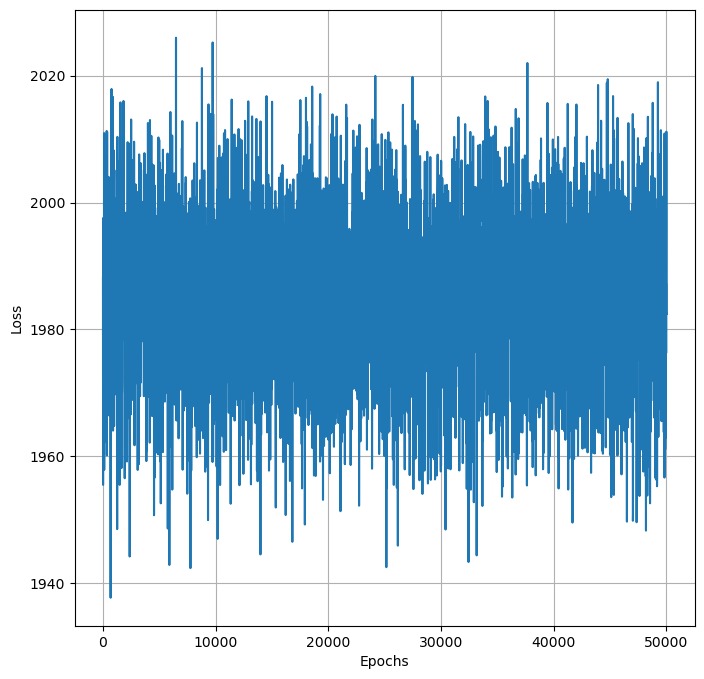

In [39]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

In [40]:
loss = jnp.load('scores/R'+str(N)+'/s2/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  490


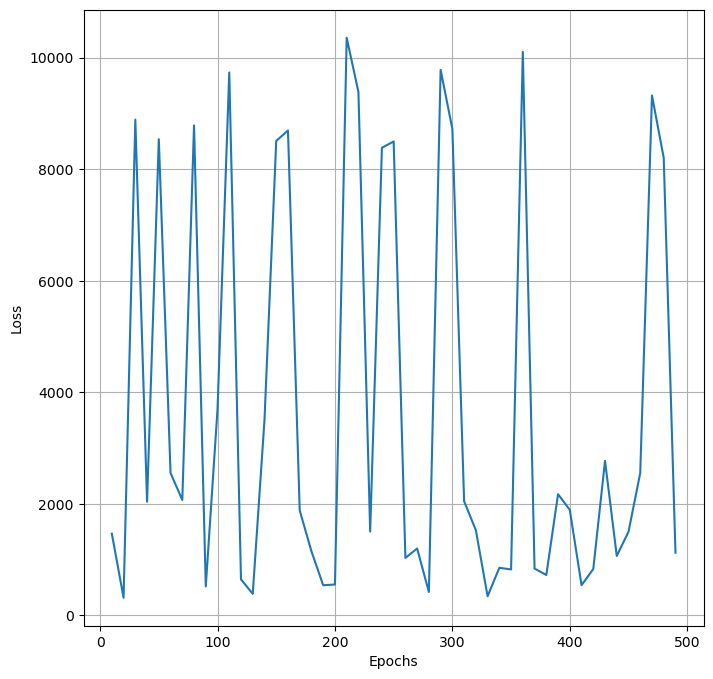

In [41]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [42]:
xs = pd.read_csv('Data/R'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/R'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

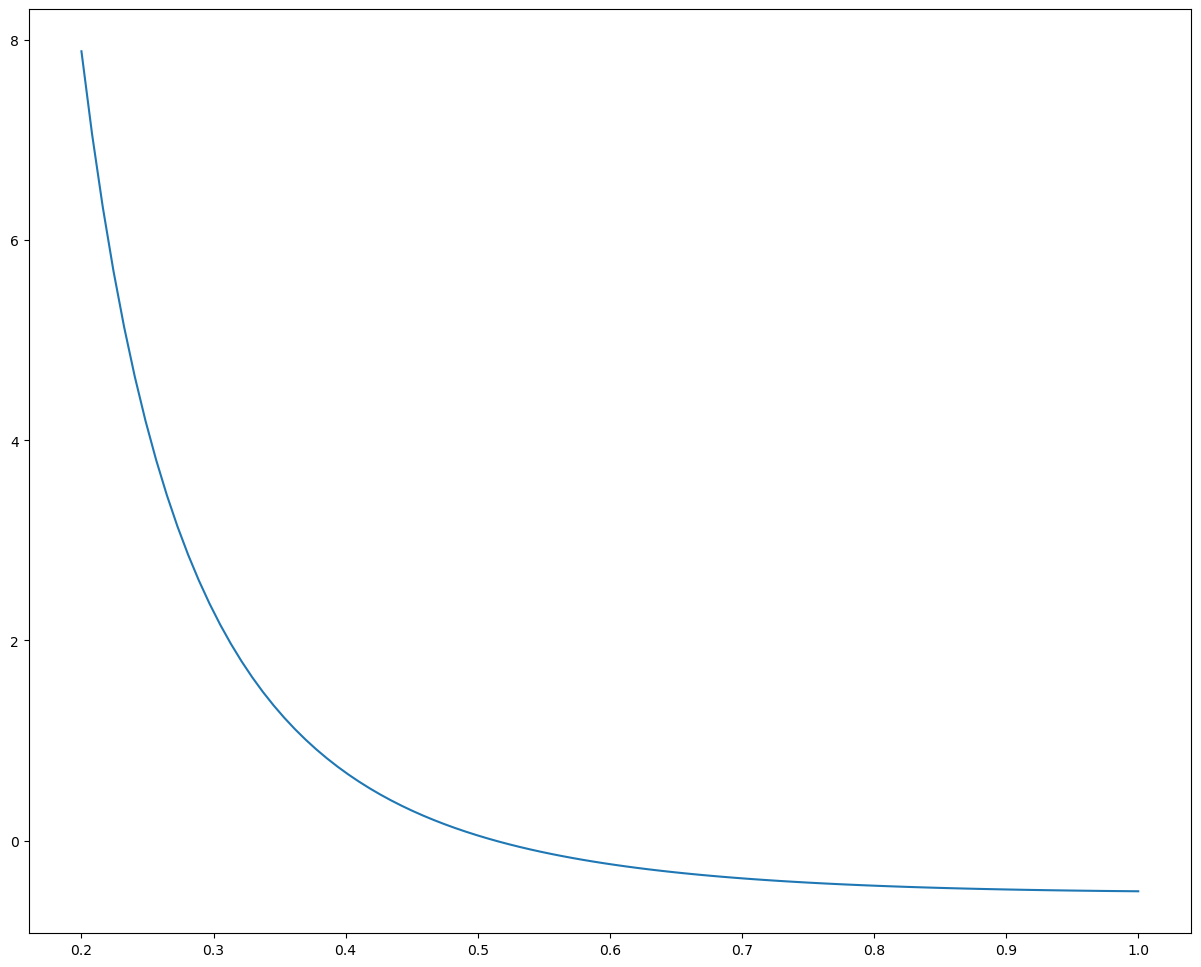

In [43]:
val = vmap(lambda t: jnp.mean(vmap(lambda x,chart: gradt_log(x0, (x,chart), t))(X_obs[0],X_obs[1]), axis=0))(jnp.linspace(0.2,1,100))
plt.plot(jnp.linspace(0.2,1,100), val)

In [44]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                    step_size=0.01, max_iter=1000)

In [39]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 1.142622e+01 | T: ((Array([ 0.00431354, -0.01948302], dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 1.032720e+01 | T: ((Array([ 0.00643428, -0.00989969], dtype=float32), Array(0.21992944, dtype=float32)), Array([0.], dtype=float32))
Final 1 | T: 1.032720e+01 | T: (Array([ 0.00643428, -0.00989969], dtype=float32), Array(0.21992944, dtype=float32))
Step 0 | T: 1.142622e+01 | T: ((Array([ 0.00431354, -0.01948302], dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 1.032720e+01 | T: ((Array([ 0.00643428, -0.00989969], dtype=float32), Array(0.21992944, dtype=float32)), Array([0.], dtype=float32))
Step 2 | T: 9.392080e+00 | T: ((Array([ 0.00410805, -0.00118478], dtype=float32), Array(0.22974923, dtype=float32)), Array([0.], dtype=float32))
Step 3 | T: 8.592904e+00 | T: ((Array([0.00051343, 0.00614951], dtype=float32), Array(0.23942587, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 7.90

Step 54 | T: 2.582335e+00 | T: ((Array([-7.6640288e-05, -9.3723054e-04], dtype=float32), Array(0.48385808, dtype=float32)), Array([0.], dtype=float32))
Step 55 | T: 2.572120e+00 | T: ((Array([-1.5851223e-05, -1.1194890e-03], dtype=float32), Array(0.48588055, dtype=float32)), Array([0.], dtype=float32))
Step 56 | T: 2.562302e+00 | T: ((Array([ 9.6009302e-05, -1.2377718e-03], dtype=float32), Array(0.48786432, dtype=float32)), Array([0.], dtype=float32))
Step 57 | T: 2.552856e+00 | T: ((Array([ 0.00024055, -0.00129436], dtype=float32), Array(0.48981115, dtype=float32)), Array([0.], dtype=float32))
Step 58 | T: 2.543761e+00 | T: ((Array([ 0.00039706, -0.0012932 ], dtype=float32), Array(0.49172273, dtype=float32)), Array([0.], dtype=float32))
Step 59 | T: 2.534996e+00 | T: ((Array([ 0.00054522, -0.00123962], dtype=float32), Array(0.49360064, dtype=float32)), Array([0.], dtype=float32))
Step 60 | T: 2.526543e+00 | T: ((Array([ 0.00066762, -0.00114005], dtype=float32), Array(0.49544635, dtype

In [45]:
mu_opt, T_opt = M.mlxt_hk(X_obs)

In [46]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[0][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0032 -0.0164 )
T = 0.5200


In [171]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgex[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:


NameError: name 'mu_bridgex' is not defined

In [71]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_opt[0]), ")")
print(f"T = {T_opt:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( -0.0029 0.0159 0.0126 0.0076 0.0259 0.0032 0.0170 -0.0077 0.0008 0.0018 )
T = 0.5148


In [157]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[0]-mu_sm[0][-1])/N:.5f} \n -T error = {jnp.abs(T_sm[-1][0]-T_opt):.5f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[0]-mu_bridgex[-1])/N:.5f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt):.5f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.00510 
 -T error = 0.35292


NameError: name 'mu_bridgex' is not defined

In [20]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

264 ms ± 2.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%timeit M.diffusion_mean(X_obs,num_steps=100, N=1)

Step 0 | T: 1.101120e+01 | T: ((Array([0.05457994, 0.12616831], dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 9.925315e+00 | T: ((Array([0.04486996, 0.11626425], dtype=float32), Array(0.21992762, dtype=float32)), Array([0.], dtype=float32))
Step 2 | T: 9.004430e+00 | T: ((Array([0.03572655, 0.10651977], dtype=float32), Array(0.22974285, dtype=float32)), Array([0.], dtype=float32))
Step 3 | T: 8.221049e+00 | T: ((Array([0.02746652, 0.09699648], dtype=float32), Array(0.23941153, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 7.552216e+00 | T: ((Array([0.02039011, 0.08775266], dtype=float32), Array(0.24890527, dtype=float32)), Array([0.], dtype=float32))
Step 5 | T: 6.978842e+00 | T: ((Array([0.01470873, 0.07884187], dtype=float32), Array(0.25820103, dtype=float32)), Array([0.], dtype=float32))
Step 6 | T: 6.485114e+00 | T: ((Array([0.01049948, 0.07031186], dtype=float32), Array(0.26728055, dtype=float32)), Array([0.], dtype=float32))

Step 60 | T: 2.441184e+00 | T: ((Array([0.02615851, 0.02810358], dtype=float32), Array(0.49330208, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 2.433720e+00 | T: ((Array([0.02645576, 0.02844379], dtype=float32), Array(0.49507967, dtype=float32)), Array([0.], dtype=float32))
Step 62 | T: 2.426516e+00 | T: ((Array([0.02672016, 0.0287373 ], dtype=float32), Array(0.49682784, dtype=float32)), Array([0.], dtype=float32))
Step 63 | T: 2.419556e+00 | T: ((Array([0.02694853, 0.02898638], dtype=float32), Array(0.49854785, dtype=float32)), Array([0.], dtype=float32))
Step 64 | T: 2.412827e+00 | T: ((Array([0.02713881, 0.02919341], dtype=float32), Array(0.50024086, dtype=float32)), Array([0.], dtype=float32))
Step 65 | T: 2.406319e+00 | T: ((Array([0.02729004, 0.02936081], dtype=float32), Array(0.50190794, dtype=float32)), Array([0.], dtype=float32))
Step 66 | T: 2.400018e+00 | T: ((Array([0.02740225, 0.0294911 ], dtype=float32), Array(0.5035501, dtype=float32)), Array([0.], dtype=flo

Step 18 | T: 3.714557e+00 | T: ((Array([0.02451969, 0.00557308], dtype=float32), Array(0.35709712, dtype=float32)), Array([0.], dtype=float32))
Step 19 | T: 3.614095e+00 | T: ((Array([0.02686843, 0.00327923], dtype=float32), Array(0.3630226, dtype=float32)), Array([0.], dtype=float32))
Step 20 | T: 3.523184e+00 | T: ((Array([0.02898744, 0.00138313], dtype=float32), Array(0.36873305, dtype=float32)), Array([0.], dtype=float32))
Step 21 | T: 3.440681e+00 | T: ((Array([ 0.03083987, -0.00014044], dtype=float32), Array(0.37423578, dtype=float32)), Array([0.], dtype=float32))
Step 22 | T: 3.365597e+00 | T: ((Array([ 0.03240108, -0.00131718], dtype=float32), Array(0.3795382, dtype=float32)), Array([0.], dtype=float32))
Step 23 | T: 3.297084e+00 | T: ((Array([ 0.03365772, -0.00217299], dtype=float32), Array(0.38464782, dtype=float32)), Array([0.], dtype=float32))
Step 24 | T: 3.234403e+00 | T: ((Array([ 0.03460664, -0.00273363], dtype=float32), Array(0.38957214, dtype=float32)), Array([0.], dt

Step 76 | T: 2.346492e+00 | T: ((Array([0.02689509, 0.02929852], dtype=float32), Array(0.51878774, dtype=float32)), Array([0.], dtype=float32))
Step 77 | T: 2.341930e+00 | T: ((Array([0.02676043, 0.02918104], dtype=float32), Array(0.5202085, dtype=float32)), Array([0.], dtype=float32))
Step 78 | T: 2.337489e+00 | T: ((Array([0.02662577, 0.02905404], dtype=float32), Array(0.5216128, dtype=float32)), Array([0.], dtype=float32))
Step 79 | T: 2.333165e+00 | T: ((Array([0.02649433, 0.02891929], dtype=float32), Array(0.5230012, dtype=float32)), Array([0.], dtype=float32))
Step 80 | T: 2.328951e+00 | T: ((Array([0.02636894, 0.02877843], dtype=float32), Array(0.52437407, dtype=float32)), Array([0.], dtype=float32))
Step 81 | T: 2.324846e+00 | T: ((Array([0.02625203, 0.02863303], dtype=float32), Array(0.5257318, dtype=float32)), Array([0.], dtype=float32))
Step 82 | T: 2.320845e+00 | T: ((Array([0.0261456 , 0.02848452], dtype=float32), Array(0.5270749, dtype=float32)), Array([0.], dtype=float32

Step 36 | T: 2.768784e+00 | T: ((Array([0.02913489, 0.00510238], dtype=float32), Array(0.43679523, dtype=float32)), Array([0.], dtype=float32))
Step 37 | T: 2.745037e+00 | T: ((Array([0.02814251, 0.00637389], dtype=float32), Array(0.4399364, dtype=float32)), Array([0.], dtype=float32))
Step 38 | T: 2.722742e+00 | T: ((Array([0.02719408, 0.00766799], dtype=float32), Array(0.44298163, dtype=float32)), Array([0.], dtype=float32))
Step 39 | T: 2.701779e+00 | T: ((Array([0.02630818, 0.00897327], dtype=float32), Array(0.44593576, dtype=float32)), Array([0.], dtype=float32))
Step 40 | T: 2.682040e+00 | T: ((Array([0.02550011, 0.01027933], dtype=float32), Array(0.4488033, dtype=float32)), Array([0.], dtype=float32))
Step 41 | T: 2.663427e+00 | T: ((Array([0.02478191, 0.01157677], dtype=float32), Array(0.45158866, dtype=float32)), Array([0.], dtype=float32))
Step 42 | T: 2.645850e+00 | T: ((Array([0.02416234, 0.01285718], dtype=float32), Array(0.45429593, dtype=float32)), Array([0.], dtype=floa

Step 95 | T: 2.276785e+00 | T: ((Array([0.02591143, 0.02673073], dtype=float32), Array(0.5433464, dtype=float32)), Array([0.], dtype=float32))
Step 96 | T: 2.273915e+00 | T: ((Array([0.02595641, 0.02663142], dtype=float32), Array(0.5445161, dtype=float32)), Array([0.], dtype=float32))
Step 97 | T: 2.271109e+00 | T: ((Array([0.02600375, 0.02653869], dtype=float32), Array(0.54567516, dtype=float32)), Array([0.], dtype=float32))
Step 98 | T: 2.268364e+00 | T: ((Array([0.02605208, 0.02645259], dtype=float32), Array(0.5468238, dtype=float32)), Array([0.], dtype=float32))
Step 99 | T: 2.265678e+00 | T: ((Array([0.02610011, 0.02637309], dtype=float32), Array(0.5479622, dtype=float32)), Array([0.], dtype=float32))
Final 99 | T: 2.265678e+00 | T: (Array([0.02610011, 0.02637309], dtype=float32), Array(0.5479622, dtype=float32))
Step 0 | T: 1.101120e+01 | T: ((Array([0.05457994, 0.12616831], dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 9.925315e+00 | 

Step 54 | T: 2.492363e+00 | T: ((Array([0.02400833, 0.0249743 ], dtype=float32), Array(0.48193944, dtype=float32)), Array([0.], dtype=float32))
Step 55 | T: 2.482974e+00 | T: ((Array([0.02437193, 0.02563312], dtype=float32), Array(0.48392406, dtype=float32)), Array([0.], dtype=float32))
Step 56 | T: 2.473957e+00 | T: ((Array([0.02474535, 0.02623538], dtype=float32), Array(0.4858701, dtype=float32)), Array([0.], dtype=float32))
Step 57 | T: 2.465291e+00 | T: ((Array([0.02511896, 0.02678211], dtype=float32), Array(0.4877793, dtype=float32)), Array([0.], dtype=float32))
Step 58 | T: 2.456952e+00 | T: ((Array([0.02548401, 0.02727463], dtype=float32), Array(0.48965332, dtype=float32)), Array([0.], dtype=float32))
Step 59 | T: 2.448922e+00 | T: ((Array([0.02583275, 0.02771452], dtype=float32), Array(0.49149376, dtype=float32)), Array([0.], dtype=float32))
Step 60 | T: 2.441184e+00 | T: ((Array([0.02615851, 0.02810358], dtype=float32), Array(0.49330208, dtype=float32)), Array([0.], dtype=floa

Step 11 | T: 4.830134e+00 | T: ((Array([0.00754235, 0.03455614], dtype=float32), Array(0.30906335, dtype=float32)), Array([0.], dtype=float32))
Step 12 | T: 4.610036e+00 | T: ((Array([0.00933853, 0.02891828], dtype=float32), Array(0.31666386, dtype=float32)), Array([0.], dtype=float32))
Step 13 | T: 4.415141e+00 | T: ((Array([0.01154417, 0.02379748], dtype=float32), Array(0.32401165, dtype=float32)), Array([0.], dtype=float32))
Step 14 | T: 4.241987e+00 | T: ((Array([0.01402435, 0.01918725], dtype=float32), Array(0.3311096, dtype=float32)), Array([0.], dtype=float32))
Step 15 | T: 4.087654e+00 | T: ((Array([0.01665968, 0.01507639], dtype=float32), Array(0.33796182, dtype=float32)), Array([0.], dtype=float32))
Step 16 | T: 3.949661e+00 | T: ((Array([0.01934541, 0.01144975], dtype=float32), Array(0.34457326, dtype=float32)), Array([0.], dtype=float32))
Step 17 | T: 3.825896e+00 | T: ((Array([0.02199098, 0.00828896], dtype=float32), Array(0.3509496, dtype=float32)), Array([0.], dtype=floa

Step 68 | T: 2.388000e+00 | T: ((Array([0.02751427, 0.02965042], dtype=float32), Array(0.50676346, dtype=float32)), Array([0.], dtype=float32))
Step 69 | T: 2.382265e+00 | T: ((Array([0.02751829, 0.0296845 ], dtype=float32), Array(0.5083364, dtype=float32)), Array([0.], dtype=float32))
Step 70 | T: 2.376699e+00 | T: ((Array([0.0274915 , 0.02969153], dtype=float32), Array(0.509888, dtype=float32)), Array([0.], dtype=float32))
Step 71 | T: 2.371297e+00 | T: ((Array([0.02743739, 0.02967397], dtype=float32), Array(0.51141894, dtype=float32)), Array([0.], dtype=float32))
Step 72 | T: 2.366051e+00 | T: ((Array([0.02735976, 0.0296342 ], dtype=float32), Array(0.51293, dtype=float32)), Array([0.], dtype=float32))
Step 73 | T: 2.360953e+00 | T: ((Array([0.02726262, 0.02957456], dtype=float32), Array(0.51442176, dtype=float32)), Array([0.], dtype=float32))
Step 74 | T: 2.355998e+00 | T: ((Array([0.02715008, 0.0294973 ], dtype=float32), Array(0.51589495, dtype=float32)), Array([0.], dtype=float32)

Step 27 | T: 3.075374e+00 | T: ((Array([ 0.03570121, -0.00289564], dtype=float32), Array(0.40330765, dtype=float32)), Array([0.], dtype=float32))
Step 28 | T: 3.030415e+00 | T: ((Array([ 0.0355458 , -0.00252333], dtype=float32), Array(0.40756452, dtype=float32)), Array([0.], dtype=float32))
Step 29 | T: 2.988820e+00 | T: ((Array([ 0.03517374, -0.0019759 ], dtype=float32), Array(0.41167232, dtype=float32)), Array([0.], dtype=float32))
Step 30 | T: 2.950265e+00 | T: ((Array([ 0.03461554, -0.0012747 ], dtype=float32), Array(0.41563782, dtype=float32)), Array([0.], dtype=float32))
Step 31 | T: 2.914463e+00 | T: ((Array([ 0.0339031 , -0.00044005], dtype=float32), Array(0.41946757, dtype=float32)), Array([0.], dtype=float32))
Step 32 | T: 2.881161e+00 | T: ((Array([0.03306882, 0.00050887], dtype=float32), Array(0.42316794, dtype=float32)), Array([0.], dtype=float32))
Step 33 | T: 2.850133e+00 | T: ((Array([0.03214474, 0.00155397], dtype=float32), Array(0.4267451, dtype=float32)), Array([0.],

Step 85 | T: 2.309424e+00 | T: ((Array([0.0259027, 0.028033 ], dtype=float32), Array(0.5310196, dtype=float32)), Array([0.], dtype=float32))
Step 86 | T: 2.305802e+00 | T: ((Array([0.0258496 , 0.02788419], dtype=float32), Array(0.5323075, dtype=float32)), Array([0.], dtype=float32))
Step 87 | T: 2.302266e+00 | T: ((Array([0.02581067, 0.02773781], dtype=float32), Array(0.5335824, dtype=float32)), Array([0.], dtype=float32))
Step 88 | T: 2.298815e+00 | T: ((Array([0.02578549, 0.02759465], dtype=float32), Array(0.5348446, dtype=float32)), Array([0.], dtype=float32))
Step 89 | T: 2.295444e+00 | T: ((Array([0.02577341, 0.02745543], dtype=float32), Array(0.53609437, dtype=float32)), Array([0.], dtype=float32))
Step 90 | T: 2.292151e+00 | T: ((Array([0.02577347, 0.02732074], dtype=float32), Array(0.537332, dtype=float32)), Array([0.], dtype=float32))
Step 91 | T: 2.288935e+00 | T: ((Array([0.02578453, 0.02719111], dtype=float32), Array(0.53855777, dtype=float32)), Array([0.], dtype=float32))


Step 42 | T: 2.645850e+00 | T: ((Array([0.02416234, 0.01285718], dtype=float32), Array(0.45429593, dtype=float32)), Array([0.], dtype=float32))
Step 43 | T: 2.629228e+00 | T: ((Array([0.023647  , 0.01411307], dtype=float32), Array(0.45692906, dtype=float32)), Array([0.], dtype=float32))
Step 44 | T: 2.613487e+00 | T: ((Array([0.02323852, 0.01533784], dtype=float32), Array(0.4594918, dtype=float32)), Array([0.], dtype=float32))
Step 45 | T: 2.598559e+00 | T: ((Array([0.02293675, 0.01652574], dtype=float32), Array(0.46198764, dtype=float32)), Array([0.], dtype=float32))
Step 46 | T: 2.584384e+00 | T: ((Array([0.02273902, 0.01767184], dtype=float32), Array(0.46442, dtype=float32)), Array([0.], dtype=float32))
Step 47 | T: 2.570907e+00 | T: ((Array([0.02264049, 0.01877196], dtype=float32), Array(0.46679202, dtype=float32)), Array([0.], dtype=float32))
Step 48 | T: 2.558077e+00 | T: ((Array([0.0226344 , 0.01982265], dtype=float32), Array(0.4691067, dtype=float32)), Array([0.], dtype=float32

Step 0 | T: 1.101120e+01 | T: ((Array([0.05457994, 0.12616831], dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 9.925315e+00 | T: ((Array([0.04486996, 0.11626425], dtype=float32), Array(0.21992762, dtype=float32)), Array([0.], dtype=float32))
Step 2 | T: 9.004430e+00 | T: ((Array([0.03572655, 0.10651977], dtype=float32), Array(0.22974285, dtype=float32)), Array([0.], dtype=float32))
Step 3 | T: 8.221049e+00 | T: ((Array([0.02746652, 0.09699648], dtype=float32), Array(0.23941153, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 7.552216e+00 | T: ((Array([0.02039011, 0.08775266], dtype=float32), Array(0.24890527, dtype=float32)), Array([0.], dtype=float32))
Step 5 | T: 6.978842e+00 | T: ((Array([0.01470873, 0.07884187], dtype=float32), Array(0.25820103, dtype=float32)), Array([0.], dtype=float32))
Step 6 | T: 6.485114e+00 | T: ((Array([0.01049948, 0.07031186], dtype=float32), Array(0.26728055, dtype=float32)), Array([0.], dtype=float32))

Step 60 | T: 2.441184e+00 | T: ((Array([0.02615851, 0.02810358], dtype=float32), Array(0.49330208, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 2.433720e+00 | T: ((Array([0.02645576, 0.02844379], dtype=float32), Array(0.49507967, dtype=float32)), Array([0.], dtype=float32))
Step 62 | T: 2.426516e+00 | T: ((Array([0.02672016, 0.0287373 ], dtype=float32), Array(0.49682784, dtype=float32)), Array([0.], dtype=float32))
Step 63 | T: 2.419556e+00 | T: ((Array([0.02694853, 0.02898638], dtype=float32), Array(0.49854785, dtype=float32)), Array([0.], dtype=float32))
Step 64 | T: 2.412827e+00 | T: ((Array([0.02713881, 0.02919341], dtype=float32), Array(0.50024086, dtype=float32)), Array([0.], dtype=float32))
Step 65 | T: 2.406319e+00 | T: ((Array([0.02729004, 0.02936081], dtype=float32), Array(0.50190794, dtype=float32)), Array([0.], dtype=float32))
Step 66 | T: 2.400018e+00 | T: ((Array([0.02740225, 0.0294911 ], dtype=float32), Array(0.5035501, dtype=float32)), Array([0.], dtype=flo

In [ ]:
#Plotting time difference




# Circle

## Defining Manifold and Loading Score

In [4]:
M = S1()
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.])

using M.Exp for Logarithm


In [5]:
file_path = 'scores/S1/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)
layers = [50,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

## Loading Loss

In [6]:
loss = jnp.load('scores/S1/s1_'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


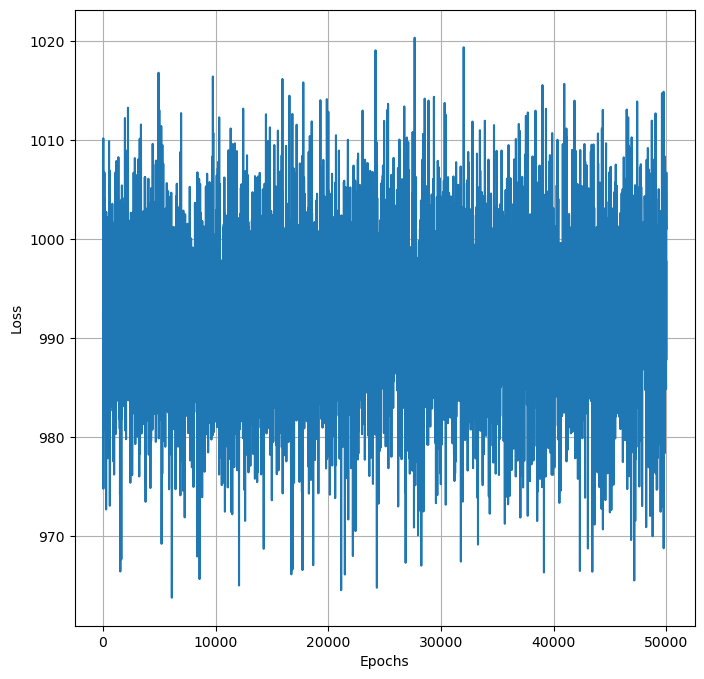

In [7]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [8]:
xs = pd.read_csv('Data/S1/xs.csv', header=None)
charts = pd.read_csv('Data/S1/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [9]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[0][0]), jnp.array([0.2]), 
                                     step_size=0.01, max_iter=100)

In [10]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

TypeError: dot_general requires contracting dimensions to have the same shape, got (1,) and (2,).

In [13]:
def gradt_log_opt(x,y,t):
    
    s1_val = M.grady_log_hk(x,y,t)
    s2_val = jacfwdx(lambda y: M.grady_log_hk(x,y,t))(y)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div).squeeze()

In [14]:
diffusion_mean(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t), s2_model = gradt_log_opt, method="Gradient")
mu_opt, T_opt, _, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]))

TypeError: Scanned function carry input and carry output must have equal types (e.g. shapes and dtypes of arrays), but they differ:
  * the input carry component carry[0][1] has type float32[2] but the corresponding output carry component has type float32[1], so the shapes do not match

Revise the scanned function so that all output types (e.g. shapes and dtypes) match the corresponding input types.

In [18]:
mu_smchart = mu_sm[0][-1]

In [19]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_smchart), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 2.0329 )
T = 1.0000


In [20]:
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1][-1]-mu_sm[1][-1]):.5f} \n -T error = {jnp.abs(T_sm[-1][0]-T_opt[-1][0]):.5f}")

NameError: name 'mu_opt' is not defined

In [33]:
mu_bridge = M.F((mu_bridgex[-1], mu_bridgechart[-1]))

In [34]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridge), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( 0.9567 0.2912 )
T = 0.5128


In [35]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_opt[1][-1]), ")")
print(f"T = {T_opt[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 1.0000 0.0002 )
T = 0.0716


In [36]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1][-1]-mu_sm[1][-1]):.5f} \n -T error = {jnp.abs(T_sm[-1][0]-T_opt[-1][0]):.5f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1][-1]-mu_bridgechart[-1]):.5f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt[-1][0]):.5f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.78229 
 -T error = 0.92626
Bridge Diffusion mean: 
 -mean error = 0.00017 
 -T error = 0.44123


In [37]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

337 ms ± 3.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
%timeit M.diffusion_mean(X_obs,num_steps=100, N=1)

Step 0 | T: 1.852988e+01 | T: ((Array([-0.23001227], dtype=float32), Array(0.20999993, dtype=float32)), Array([1., 0.], dtype=float32))
Step 1 | T: 1.651170e+01 | T: ((Array([-0.22005376], dtype=float32), Array(0.21992284, dtype=float32)), Array([1., 0.], dtype=float32))
Step 2 | T: 1.479264e+01 | T: ((Array([-0.2101603], dtype=float32), Array(0.22972557, dtype=float32)), Array([1., 0.], dtype=float32))
Step 3 | T: 1.332320e+01 | T: ((Array([-0.20035248], dtype=float32), Array(0.23937148, dtype=float32)), Array([1., 0.], dtype=float32))
Step 4 | T: 1.206231e+01 | T: ((Array([-0.19064815], dtype=float32), Array(0.24883002, dtype=float32)), Array([1., 0.], dtype=float32))
Step 5 | T: 1.097600e+01 | T: ((Array([-0.18106249], dtype=float32), Array(0.25807643, dtype=float32)), Array([1., 0.], dtype=float32))
Step 6 | T: 1.003619e+01 | T: ((Array([-0.17160816], dtype=float32), Array(0.2670912, dtype=float32)), Array([1., 0.], dtype=float32))
Step 7 | T: 9.219672e+00 | T: ((Array([-0.16229557

Step 61 | T: 1.765231e+00 | T: ((Array([0.15533094], dtype=float32), Array(0.4775787, dtype=float32)), Array([1., 0.], dtype=float32))
Step 62 | T: 1.743972e+00 | T: ((Array([0.15936193], dtype=float32), Array(0.47891006, dtype=float32)), Array([1., 0.], dtype=float32))
Step 63 | T: 1.723262e+00 | T: ((Array([0.16336693], dtype=float32), Array(0.48021078, dtype=float32)), Array([1., 0.], dtype=float32))
Step 64 | T: 1.703075e+00 | T: ((Array([0.16734692], dtype=float32), Array(0.481482, dtype=float32)), Array([1., 0.], dtype=float32))
Step 65 | T: 1.683385e+00 | T: ((Array([0.17130281], dtype=float32), Array(0.4827248, dtype=float32)), Array([1., 0.], dtype=float32))
Step 66 | T: 1.664172e+00 | T: ((Array([0.17523544], dtype=float32), Array(0.48394015, dtype=float32)), Array([1., 0.], dtype=float32))
Step 67 | T: 1.645412e+00 | T: ((Array([0.1791456], dtype=float32), Array(0.48512906, dtype=float32)), Array([1., 0.], dtype=float32))
Step 68 | T: 1.627086e+00 | T: ((Array([0.18303408], 

Step 21 | T: 4.075386e+00 | T: ((Array([-0.04890837], dtype=float32), Array(0.37125227, dtype=float32)), Array([1., 0.], dtype=float32))
Step 22 | T: 3.919297e+00 | T: ((Array([-0.04200172], dtype=float32), Array(0.3762729, dtype=float32)), Array([1., 0.], dtype=float32))
Step 23 | T: 3.775929e+00 | T: ((Array([-0.03523772], dtype=float32), Array(0.3810926, dtype=float32)), Array([1., 0.], dtype=float32))
Step 24 | T: 3.643910e+00 | T: ((Array([-0.02861202], dtype=float32), Array(0.3857195, dtype=float32)), Array([1., 0.], dtype=float32))
Step 25 | T: 3.522033e+00 | T: ((Array([-0.02212016], dtype=float32), Array(0.39016163, dtype=float32)), Array([1., 0.], dtype=float32))
Step 26 | T: 3.409250e+00 | T: ((Array([-0.01575764], dtype=float32), Array(0.39442685, dtype=float32)), Array([1., 0.], dtype=float32))
Step 27 | T: 3.304638e+00 | T: ((Array([-0.00951992], dtype=float32), Array(0.39852297, dtype=float32)), Array([1., 0.], dtype=float32))
Step 28 | T: 3.207382e+00 | T: ((Array([-0.0

Step 82 | T: 1.407408e+00 | T: ((Array([0.23552549], dtype=float32), Array(0.50028527, dtype=float32)), Array([1., 0.], dtype=float32))
Step 83 | T: 1.393872e+00 | T: ((Array([0.23915423], dtype=float32), Array(0.5011429, dtype=float32)), Array([1., 0.], dtype=float32))
Step 84 | T: 1.380572e+00 | T: ((Array([0.2427688], dtype=float32), Array(0.501984, dtype=float32)), Array([1., 0.], dtype=float32))
Step 85 | T: 1.367503e+00 | T: ((Array([0.24636945], dtype=float32), Array(0.5028088, dtype=float32)), Array([1., 0.], dtype=float32))
Step 86 | T: 1.354655e+00 | T: ((Array([0.24995646], dtype=float32), Array(0.50361764, dtype=float32)), Array([1., 0.], dtype=float32))
Step 87 | T: 1.342025e+00 | T: ((Array([0.25353009], dtype=float32), Array(0.50441086, dtype=float32)), Array([1., 0.], dtype=float32))
Step 88 | T: 1.329604e+00 | T: ((Array([0.25709054], dtype=float32), Array(0.50518876, dtype=float32)), Array([1., 0.], dtype=float32))
Step 89 | T: 1.317386e+00 | T: ((Array([0.26063803], 

Step 42 | T: 2.330246e+00 | T: ((Array([0.07200319], dtype=float32), Array(0.44426972, dtype=float32)), Array([1., 0.], dtype=float32))
Step 43 | T: 2.289187e+00 | T: ((Array([0.07681054], dtype=float32), Array(0.44653004, dtype=float32)), Array([1., 0.], dtype=float32))
Step 44 | T: 2.249915e+00 | T: ((Array([0.08155822], dtype=float32), Array(0.44871762, dtype=float32)), Array([1., 0.], dtype=float32))
Step 45 | T: 2.212302e+00 | T: ((Array([0.08624896], dtype=float32), Array(0.45083603, dtype=float32)), Array([1., 0.], dtype=float32))
Step 46 | T: 2.176231e+00 | T: ((Array([0.09088535], dtype=float32), Array(0.45288864, dtype=float32)), Array([1., 0.], dtype=float32))
Step 47 | T: 2.141595e+00 | T: ((Array([0.09546988], dtype=float32), Array(0.45487866, dtype=float32)), Array([1., 0.], dtype=float32))
Step 48 | T: 2.108297e+00 | T: ((Array([0.1000049], dtype=float32), Array(0.4568091, dtype=float32)), Array([1., 0.], dtype=float32))
Step 49 | T: 2.076249e+00 | T: ((Array([0.10449263

Step 2 | T: 1.479264e+01 | T: ((Array([-0.2101603], dtype=float32), Array(0.22972557, dtype=float32)), Array([1., 0.], dtype=float32))
Step 3 | T: 1.332320e+01 | T: ((Array([-0.20035248], dtype=float32), Array(0.23937148, dtype=float32)), Array([1., 0.], dtype=float32))
Step 4 | T: 1.206231e+01 | T: ((Array([-0.19064815], dtype=float32), Array(0.24883002, dtype=float32)), Array([1., 0.], dtype=float32))
Step 5 | T: 1.097600e+01 | T: ((Array([-0.18106249], dtype=float32), Array(0.25807643, dtype=float32)), Array([1., 0.], dtype=float32))
Step 6 | T: 1.003619e+01 | T: ((Array([-0.17160816], dtype=float32), Array(0.2670912, dtype=float32)), Array([1., 0.], dtype=float32))
Step 7 | T: 9.219672e+00 | T: ((Array([-0.16229557], dtype=float32), Array(0.27585956, dtype=float32)), Array([1., 0.], dtype=float32))
Step 8 | T: 8.507276e+00 | T: ((Array([-0.15313306], dtype=float32), Array(0.28437072, dtype=float32)), Array([1., 0.], dtype=float32))
Step 9 | T: 7.883114e+00 | T: ((Array([-0.14412718

Step 63 | T: 1.723261e+00 | T: ((Array([0.16336696], dtype=float32), Array(0.48021078, dtype=float32)), Array([1., 0.], dtype=float32))
Step 64 | T: 1.703075e+00 | T: ((Array([0.16734695], dtype=float32), Array(0.481482, dtype=float32)), Array([1., 0.], dtype=float32))
Step 65 | T: 1.683385e+00 | T: ((Array([0.17130284], dtype=float32), Array(0.4827248, dtype=float32)), Array([1., 0.], dtype=float32))
Step 66 | T: 1.664171e+00 | T: ((Array([0.17523547], dtype=float32), Array(0.48394015, dtype=float32)), Array([1., 0.], dtype=float32))
Step 67 | T: 1.645412e+00 | T: ((Array([0.17914563], dtype=float32), Array(0.48512906, dtype=float32)), Array([1., 0.], dtype=float32))
Step 68 | T: 1.627086e+00 | T: ((Array([0.1830341], dtype=float32), Array(0.48629236, dtype=float32)), Array([1., 0.], dtype=float32))
Step 69 | T: 1.609175e+00 | T: ((Array([0.18690158], dtype=float32), Array(0.48743093, dtype=float32)), Array([1., 0.], dtype=float32))
Step 70 | T: 1.591661e+00 | T: ((Array([0.19074874],

Step 23 | T: 3.775930e+00 | T: ((Array([-0.03523771], dtype=float32), Array(0.38109258, dtype=float32)), Array([1., 0.], dtype=float32))
Step 24 | T: 3.643910e+00 | T: ((Array([-0.02861201], dtype=float32), Array(0.38571948, dtype=float32)), Array([1., 0.], dtype=float32))
Step 25 | T: 3.522034e+00 | T: ((Array([-0.02212015], dtype=float32), Array(0.3901616, dtype=float32)), Array([1., 0.], dtype=float32))
Step 26 | T: 3.409251e+00 | T: ((Array([-0.01575763], dtype=float32), Array(0.39442682, dtype=float32)), Array([1., 0.], dtype=float32))
Step 27 | T: 3.304639e+00 | T: ((Array([-0.00951991], dtype=float32), Array(0.39852294, dtype=float32)), Array([1., 0.], dtype=float32))
Step 28 | T: 3.207383e+00 | T: ((Array([-0.00340244], dtype=float32), Array(0.4024575, dtype=float32)), Array([1., 0.], dtype=float32))
Step 29 | T: 3.116768e+00 | T: ((Array([0.00259931], dtype=float32), Array(0.40623787, dtype=float32)), Array([1., 0.], dtype=float32))
Step 30 | T: 3.032159e+00 | T: ((Array([0.00

Step 84 | T: 1.380572e+00 | T: ((Array([0.24276878], dtype=float32), Array(0.501984, dtype=float32)), Array([1., 0.], dtype=float32))
Step 85 | T: 1.367503e+00 | T: ((Array([0.24636944], dtype=float32), Array(0.5028088, dtype=float32)), Array([1., 0.], dtype=float32))
Step 86 | T: 1.354656e+00 | T: ((Array([0.24995644], dtype=float32), Array(0.50361764, dtype=float32)), Array([1., 0.], dtype=float32))
Step 87 | T: 1.342025e+00 | T: ((Array([0.25353006], dtype=float32), Array(0.50441086, dtype=float32)), Array([1., 0.], dtype=float32))
Step 88 | T: 1.329604e+00 | T: ((Array([0.2570905], dtype=float32), Array(0.50518876, dtype=float32)), Array([1., 0.], dtype=float32))
Step 89 | T: 1.317386e+00 | T: ((Array([0.260638], dtype=float32), Array(0.5059516, dtype=float32)), Array([1., 0.], dtype=float32))
Step 90 | T: 1.305366e+00 | T: ((Array([0.26417276], dtype=float32), Array(0.50669956, dtype=float32)), Array([1., 0.], dtype=float32))
Step 91 | T: 1.293538e+00 | T: ((Array([0.26769498], dt

Step 44 | T: 2.249915e+00 | T: ((Array([0.08155822], dtype=float32), Array(0.44871762, dtype=float32)), Array([1., 0.], dtype=float32))
Step 45 | T: 2.212302e+00 | T: ((Array([0.08624896], dtype=float32), Array(0.45083603, dtype=float32)), Array([1., 0.], dtype=float32))
Step 46 | T: 2.176231e+00 | T: ((Array([0.09088535], dtype=float32), Array(0.45288864, dtype=float32)), Array([1., 0.], dtype=float32))
Step 47 | T: 2.141595e+00 | T: ((Array([0.09546988], dtype=float32), Array(0.45487866, dtype=float32)), Array([1., 0.], dtype=float32))
Step 48 | T: 2.108297e+00 | T: ((Array([0.1000049], dtype=float32), Array(0.4568091, dtype=float32)), Array([1., 0.], dtype=float32))
Step 49 | T: 2.076249e+00 | T: ((Array([0.10449263], dtype=float32), Array(0.4586828, dtype=float32)), Array([1., 0.], dtype=float32))
Step 50 | T: 2.045369e+00 | T: ((Array([0.10893523], dtype=float32), Array(0.46050248, dtype=float32)), Array([1., 0.], dtype=float32))
Step 51 | T: 2.015582e+00 | T: ((Array([0.11333469]

Step 4 | T: 1.206231e+01 | T: ((Array([-0.19064815], dtype=float32), Array(0.24883002, dtype=float32)), Array([1., 0.], dtype=float32))
Step 5 | T: 1.097600e+01 | T: ((Array([-0.18106249], dtype=float32), Array(0.25807643, dtype=float32)), Array([1., 0.], dtype=float32))
Step 6 | T: 1.003619e+01 | T: ((Array([-0.17160816], dtype=float32), Array(0.2670912, dtype=float32)), Array([1., 0.], dtype=float32))
Step 7 | T: 9.219672e+00 | T: ((Array([-0.16229557], dtype=float32), Array(0.27585956, dtype=float32)), Array([1., 0.], dtype=float32))
Step 8 | T: 8.507276e+00 | T: ((Array([-0.15313306], dtype=float32), Array(0.28437072, dtype=float32)), Array([1., 0.], dtype=float32))
Step 9 | T: 7.883113e+00 | T: ((Array([-0.14412718], dtype=float32), Array(0.29261747, dtype=float32)), Array([1., 0.], dtype=float32))
Step 10 | T: 7.334003e+00 | T: ((Array([-0.13528283], dtype=float32), Array(0.3005955, dtype=float32)), Array([1., 0.], dtype=float32))
Step 11 | T: 6.848979e+00 | T: ((Array([-0.126603

Step 65 | T: 1.683385e+00 | T: ((Array([0.17130286], dtype=float32), Array(0.4827248, dtype=float32)), Array([1., 0.], dtype=float32))
Step 66 | T: 1.664171e+00 | T: ((Array([0.17523548], dtype=float32), Array(0.48394015, dtype=float32)), Array([1., 0.], dtype=float32))
Step 67 | T: 1.645412e+00 | T: ((Array([0.17914565], dtype=float32), Array(0.48512906, dtype=float32)), Array([1., 0.], dtype=float32))
Step 68 | T: 1.627086e+00 | T: ((Array([0.18303412], dtype=float32), Array(0.48629236, dtype=float32)), Array([1., 0.], dtype=float32))
Step 69 | T: 1.609175e+00 | T: ((Array([0.1869016], dtype=float32), Array(0.48743093, dtype=float32)), Array([1., 0.], dtype=float32))
Step 70 | T: 1.591661e+00 | T: ((Array([0.19074875], dtype=float32), Array(0.48854554, dtype=float32)), Array([1., 0.], dtype=float32))
Step 71 | T: 1.574529e+00 | T: ((Array([0.19457622], dtype=float32), Array(0.48963696, dtype=float32)), Array([1., 0.], dtype=float32))
Step 72 | T: 1.557763e+00 | T: ((Array([0.19838458

Step 25 | T: 3.522034e+00 | T: ((Array([-0.02212015], dtype=float32), Array(0.3901616, dtype=float32)), Array([1., 0.], dtype=float32))
Step 26 | T: 3.409251e+00 | T: ((Array([-0.01575763], dtype=float32), Array(0.39442682, dtype=float32)), Array([1., 0.], dtype=float32))
Step 27 | T: 3.304639e+00 | T: ((Array([-0.00951991], dtype=float32), Array(0.39852294, dtype=float32)), Array([1., 0.], dtype=float32))
Step 28 | T: 3.207383e+00 | T: ((Array([-0.00340244], dtype=float32), Array(0.4024575, dtype=float32)), Array([1., 0.], dtype=float32))
Step 29 | T: 3.116768e+00 | T: ((Array([0.00259931], dtype=float32), Array(0.40623787, dtype=float32)), Array([1., 0.], dtype=float32))
Step 30 | T: 3.032159e+00 | T: ((Array([0.00848979], dtype=float32), Array(0.40987122, dtype=float32)), Array([1., 0.], dtype=float32))
Step 31 | T: 2.952994e+00 | T: ((Array([0.01427342], dtype=float32), Array(0.41336444, dtype=float32)), Array([1., 0.], dtype=float32))
Step 32 | T: 2.878774e+00 | T: ((Array([0.0199

Step 86 | T: 1.354656e+00 | T: ((Array([0.24995644], dtype=float32), Array(0.50361764, dtype=float32)), Array([1., 0.], dtype=float32))
Step 87 | T: 1.342025e+00 | T: ((Array([0.25353006], dtype=float32), Array(0.50441086, dtype=float32)), Array([1., 0.], dtype=float32))
Step 88 | T: 1.329604e+00 | T: ((Array([0.2570905], dtype=float32), Array(0.50518876, dtype=float32)), Array([1., 0.], dtype=float32))
Step 89 | T: 1.317386e+00 | T: ((Array([0.260638], dtype=float32), Array(0.5059516, dtype=float32)), Array([1., 0.], dtype=float32))
Step 90 | T: 1.305366e+00 | T: ((Array([0.26417276], dtype=float32), Array(0.50669956, dtype=float32)), Array([1., 0.], dtype=float32))
Step 91 | T: 1.293538e+00 | T: ((Array([0.26769498], dtype=float32), Array(0.507433, dtype=float32)), Array([1., 0.], dtype=float32))
Step 92 | T: 1.281898e+00 | T: ((Array([0.27120483], dtype=float32), Array(0.5081521, dtype=float32)), Array([1., 0.], dtype=float32))
Step 93 | T: 1.270439e+00 | T: ((Array([0.27470252], dt

# n-Sphere

## Defining Manifold and Loading Score

In [146]:
N = 10 #Change this for S2, S3, S5, S10, S20

In [147]:
M = nSphere(N=N)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*N)

using M.Exp for Logarithm


In [148]:
file_path = 'scores/S'+str(N)+'/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)
if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

## Loading Loss

In [149]:
loss = jnp.load('scores/S'+str(N)+'/s1_'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


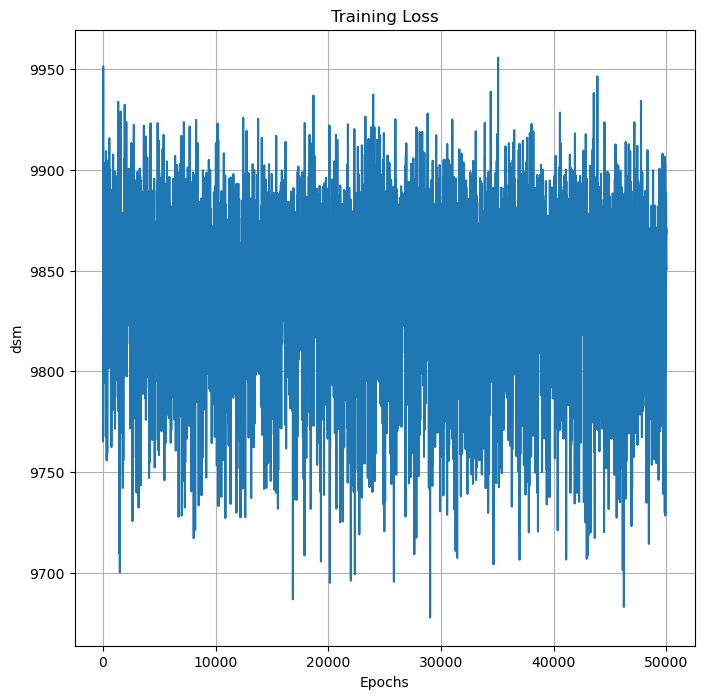

In [150]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [151]:
xs = pd.read_csv('Data/S'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/S'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [152]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")

In [153]:
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.3]), 
                                     step_size=0.001, max_iter=2000)

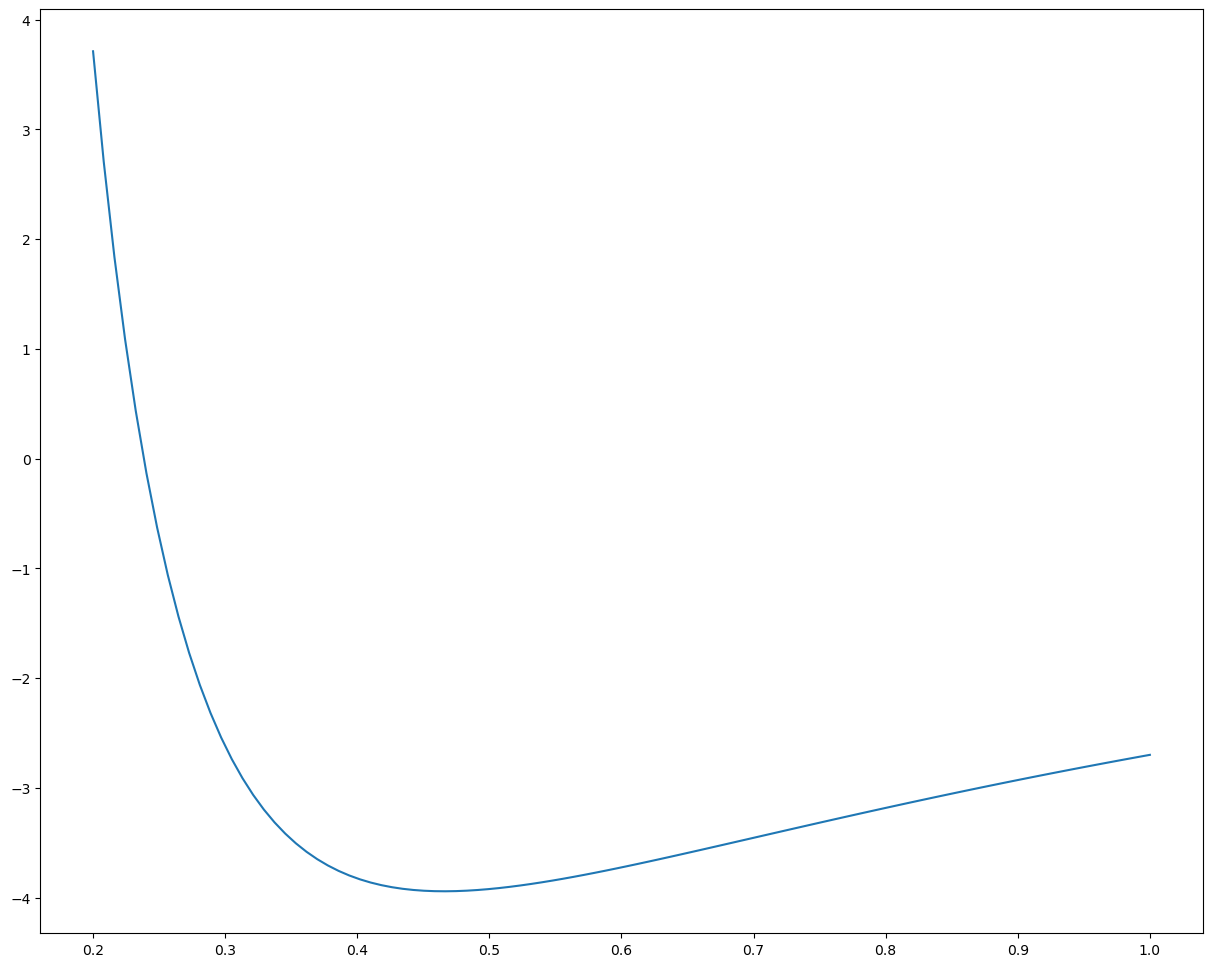

In [154]:
val = vmap(lambda t: jnp.mean(vmap(lambda x,chart: gradt_log((mu_sm[0][-1], mu_sm[1][-1]), (x,chart), t))(X_obs[0],X_obs[1]), axis=0))(jnp.linspace(0.2,1,100))
plt.plot(jnp.linspace(0.2,1,100), val)

In [51]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 1.736784e+01 | T: ((Array([-1.8853218e-10, -4.8455567e-10, -7.7671852e-10, -2.1932425e-09,
       -2.2784818e-09,  2.0860778e-09,  2.6260532e-11, -2.7344151e-09,
       -1.2368043e-08, -6.5753336e-09], dtype=float32), Array(0.20999993, dtype=float32)), Array([-0.03176528, -0.11440293,  0.05558807, -0.0720636 , -0.11384054,
       -0.41389784,  0.36698964,  0.00421244,  0.29360557, -0.27199152,
        0.7060211 ], dtype=float32))
Step 1 | T: 1.320977e+01 | T: ((Array([ 0.00807606,  0.00047359,  0.00916921,  0.0035954 ,  0.00805162,
       -0.00837327, -0.00967944, -0.00809323,  0.00801484,  0.00445966],      dtype=float32), Array(0.21991752, dtype=float32)), Array([-0.03176528, -0.11440293,  0.05558807, -0.0720636 , -0.11384054,
       -0.41389784,  0.36698964,  0.00421244,  0.29360557, -0.27199152,
        0.7060211 ], dtype=float32))
Final 1 | T: 1.320977e+01 | T: (Array([ 0.00807606,  0.00047359,  0.00916921,  0.0035954 ,  0.00805162,
       -0.00837327, -0.00967944, -0.

Step 17 | T: 1.379640e+00 | T: ((Array([-8.4274010e-10,  2.7083837e-09,  1.4231993e-09, -3.4609933e-09,
       -2.6594265e-09,  3.2632190e-09, -7.5701312e-10,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00], dtype=float32), Array(0.3465764, dtype=float32)), Array([-0.03514728, -0.04309447,  0.09156618,  0.04486958, -0.14268303,
       -0.2598482 ,  0.1977699 , -0.06345535,  0.15606503, -0.14791659,
        0.89958596], dtype=float32))
Step 18 | T: 1.123289e+00 | T: ((Array([-2.3337296e-04, -1.5770756e-03, -7.1051187e-04,  1.7978867e-03,
        1.5802243e-03, -1.8320862e-03,  9.8102835e-05, -9.2957640e-04,
        6.0585840e-04,  3.6516106e-03], dtype=float32), Array(0.3521386, dtype=float32)), Array([-0.03514728, -0.04309447,  0.09156618,  0.04486958, -0.14268303,
       -0.2598482 ,  0.1977699 , -0.06345535,  0.15606503, -0.14791659,
        0.89958596], dtype=float32))
Step 19 | T: 9.812896e-01 | T: ((Array([-2.7946517e-04, -2.6217741e-03, -1.0455619e-03,  3.1630513e-03,
    

Step 37 | T: 1.598305e-02 | T: ((Array([ 0.00232514, -0.00120211,  0.00560756, -0.00240717,  0.01881563,
       -0.02128272, -0.00044707, -0.01245352,  0.00982991,  0.03442091],      dtype=float32), Array(0.41940787, dtype=float32)), Array([-0.03514728, -0.04309447,  0.09156618,  0.04486958, -0.14268303,
       -0.2598482 ,  0.1977699 , -0.06345535,  0.15606503, -0.14791659,
        0.89958596], dtype=float32))
Step 38 | T: -1.095043e-03 | T: ((Array([ 0.00201034, -0.00094318,  0.00498712, -0.00160121,  0.01827455,
       -0.02065089, -0.0005496 , -0.01188553,  0.00934866,  0.0332817 ],      dtype=float32), Array(0.42148802, dtype=float32)), Array([-0.03514728, -0.04309447,  0.09156618,  0.04486958, -0.14268303,
       -0.2598482 ,  0.1977699 , -0.06345535,  0.15606503, -0.14791659,
        0.89958596], dtype=float32))
Step 39 | T: -1.616275e-02 | T: ((Array([ 0.00172418, -0.00045854,  0.00435991, -0.00083202,  0.01764139,
       -0.01991197, -0.0007187 , -0.0112606 ,  0.00881909,  0.0

Step 57 | T: -1.431462e-01 | T: ((Array([ 0.00214948,  0.00120336,  0.00446053, -0.0017656 ,  0.00804613,
       -0.00904146, -0.00108542, -0.00605375,  0.00515087,  0.01331256],      dtype=float32), Array(0.44726008, dtype=float32)), Array([-0.03514728, -0.04309447,  0.09156618,  0.04486958, -0.14268303,
       -0.2598482 ,  0.1977699 , -0.06345535,  0.15606503, -0.14791659,
        0.89958596], dtype=float32))
Step 58 | T: -1.432647e-01 | T: ((Array([ 0.00208378,  0.00139607,  0.00446197, -0.00145045,  0.00810476,
       -0.00912543, -0.00120594, -0.00629131,  0.00537355,  0.01335877],      dtype=float32), Array(0.44812682, dtype=float32)), Array([-0.03514728, -0.04309447,  0.09156618,  0.04486958, -0.14268303,
       -0.2598482 ,  0.1977699 , -0.06345535,  0.15606503, -0.14791659,
        0.89958596], dtype=float32))
Step 59 | T: -1.484381e-01 | T: ((Array([ 0.00200433,  0.00146108,  0.00439284, -0.00112938,  0.00821688,
       -0.00926886, -0.00131185, -0.00654004,  0.00559162,  0.

Step 77 | T: -1.771325e-01 | T: ((Array([ 0.00177894,  0.00074834,  0.003485  , -0.00112727,  0.01093373,
       -0.01232621, -0.00121545, -0.00711746,  0.00549215,  0.01902625],      dtype=float32), Array(0.45991698, dtype=float32)), Array([-0.03514728, -0.04309447,  0.09156618,  0.04486958, -0.14268303,
       -0.2598482 ,  0.1977699 , -0.06345535,  0.15606503, -0.14791659,
        0.89958596], dtype=float32))
Step 78 | T: -1.786291e-01 | T: ((Array([ 0.0017735 ,  0.00066904,  0.00356277, -0.00099073,  0.01086994,
       -0.01224247, -0.0012101 , -0.0069837 ,  0.00539747,  0.01898311],      dtype=float32), Array(0.46035963, dtype=float32)), Array([-0.03514728, -0.04309447,  0.09156618,  0.04486958, -0.14268303,
       -0.2598482 ,  0.1977699 , -0.06345535,  0.15606503, -0.14791659,
        0.89958596], dtype=float32))
Step 79 | T: -1.778921e-01 | T: ((Array([ 0.00176214,  0.00064331,  0.00361513, -0.00088823,  0.01078728,
       -0.01213515, -0.0011965 , -0.00686174,  0.00531749,  0.

Step 97 | T: -1.884199e-01 | T: ((Array([ 0.00164679,  0.00083494,  0.00322087, -0.00094598,  0.00945664,
       -0.01063371, -0.00106505, -0.00692298,  0.00560271,  0.01611987],      dtype=float32), Array(0.4667908, dtype=float32)), Array([-0.03514728, -0.04309447,  0.09156618,  0.04486958, -0.14268303,
       -0.2598482 ,  0.1977699 , -0.06345535,  0.15606503, -0.14791659,
        0.89958596], dtype=float32))
Step 98 | T: -1.891500e-01 | T: ((Array([ 0.00165568,  0.00084845,  0.00324408, -0.00093456,  0.0094803 ,
       -0.01066479, -0.00105277, -0.00694533,  0.00558333,  0.01612177],      dtype=float32), Array(0.46704742, dtype=float32)), Array([-0.03514728, -0.04309447,  0.09156618,  0.04486958, -0.14268303,
       -0.2598482 ,  0.1977699 , -0.06345535,  0.15606503, -0.14791659,
        0.89958596], dtype=float32))
Step 99 | T: -1.900799e-01 | T: ((Array([ 0.00165164,  0.00086207,  0.00327226, -0.00095097,  0.0095118 ,
       -0.01070061, -0.00105413, -0.00695671,  0.00556173,  0.0

In [144]:
#diffusion_mean.initialize(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], s2_model = lambda x,y,t: jacfwdx(lambda y: M.grady_log_hk(x,y,t)[0])(y), method="Gradient")
diffusion_mean(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], s2_model = M.gradt_log_hk, method="Gradient")
mu_opt, T_opt, _, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]))

In [145]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[1][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.2726 0.1346 0.9522 )
T = 0.5180


In [218]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:


NameError: name 'mu_bridgechart' is not defined

In [219]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_opt[1][-1]), ")")
print(f"T = {T_opt[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.1972 0.2795 -0.1738 -0.0545 -0.0874 -0.0610 0.1865 -0.3275 -0.1058 -0.1143 -0.4021 -0.0457 -0.2569 0.1579 0.1958 0.3779 -0.3512 0.1565 0.0370 0.2950 0.0085 )
T = 0.4078


In [220]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt[-1][0]):.4f}")

The difference between the score and bridge:


NameError: name 'mu_bridgechart' is not defined

In [43]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1][-1]-mu_sm[1][-1])/N:.5f} \n -T error = {jnp.abs(T_sm[-1][0]-T_opt[-1][0]):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1][-1]-mu_bridgechart[-1])/N:.5f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt[-1][0]):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.02509 
 -T error = 0.0400


NameError: name 'mu_bridgechart' is not defined

In [59]:
T_sm[-1]

Array([0.34654832], dtype=float32)

In [78]:
%timeit mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.1, max_iter=100)

809 ms ± 4.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [79]:
%timeit M.diffusion_mean(X_obs,num_steps=100)

Step 0 | T: 9.623056e+00 | T: ((Array([-2.6668883e-09, -0.0000000e+00], dtype=float32), Array(0.20999993, dtype=float32)), Array([-0.18916447, -0.06646915,  0.9796931 ], dtype=float32))
Step 1 | T: 8.450203e+00 | T: ((Array([ 0.00898598, -0.00248003], dtype=float32), Array(0.21992323, dtype=float32)), Array([-0.18916447, -0.06646915,  0.9796931 ], dtype=float32))
Step 2 | T: 7.512320e+00 | T: ((Array([ 0.01740269, -0.00782265], dtype=float32), Array(0.22973019, dtype=float32)), Array([-0.18916447, -0.06646915,  0.9796931 ], dtype=float32))
Step 3 | T: 6.700606e+00 | T: ((Array([ 0.02530241, -0.01437789], dtype=float32), Array(0.23938473, dtype=float32)), Array([-0.18916447, -0.06646915,  0.9796931 ], dtype=float32))
Step 4 | T: 6.004924e+00 | T: ((Array([ 0.03266557, -0.02153107], dtype=float32), Array(0.24885654, dtype=float32)), Array([-0.18916447, -0.06646915,  0.9796931 ], dtype=float32))
Step 5 | T: 5.410668e+00 | T: ((Array([ 0.03945813, -0.02896928], dtype=float32), Array(0.2581

Step 46 | T: 1.102494e+00 | T: ((Array([ 0.03401711, -0.02060514], dtype=float32), Array(0.46035245, dtype=float32)), Array([-0.03537175,  0.07209431,  0.9966754 ], dtype=float32))
Step 47 | T: 1.090112e+00 | T: ((Array([ 0.0332413 , -0.01938567], dtype=float32), Array(0.46264914, dtype=float32)), Array([-0.03537175,  0.07209431,  0.9966754 ], dtype=float32))
Step 48 | T: 1.077800e+00 | T: ((Array([ 0.03247004, -0.01821732], dtype=float32), Array(0.46488982, dtype=float32)), Array([-0.03537175,  0.07209431,  0.9966754 ], dtype=float32))
Step 49 | T: 1.066390e+00 | T: ((Array([ 0.03171114, -0.01710337], dtype=float32), Array(0.46707729, dtype=float32)), Array([-0.03537175,  0.07209431,  0.9966754 ], dtype=float32))
Step 50 | T: 1.055194e+00 | T: ((Array([ 0.03097202, -0.0160487 ], dtype=float32), Array(0.46921417, dtype=float32)), Array([-0.03537175,  0.07209431,  0.9966754 ], dtype=float32))
Step 51 | T: 1.044781e+00 | T: ((Array([ 0.03025797, -0.01505514], dtype=float32), Array(0.4713

Step 92 | T: 8.265152e-01 | T: ((Array([ 0.02608633, -0.01077524], dtype=float32), Array(0.53312683, dtype=float32)), Array([-0.03537175,  0.07209431,  0.9966754 ], dtype=float32))
Step 93 | T: 8.237979e-01 | T: ((Array([ 0.02610396, -0.01087986], dtype=float32), Array(0.53428453, dtype=float32)), Array([-0.03537175,  0.07209431,  0.9966754 ], dtype=float32))
Step 94 | T: 8.205805e-01 | T: ((Array([ 0.02611415, -0.01097526], dtype=float32), Array(0.5354312, dtype=float32)), Array([-0.03537175,  0.07209431,  0.9966754 ], dtype=float32))
Step 95 | T: 8.186433e-01 | T: ((Array([ 0.0261159 , -0.01106048], dtype=float32), Array(0.53656715, dtype=float32)), Array([-0.03537175,  0.07209431,  0.9966754 ], dtype=float32))
Step 96 | T: 8.158538e-01 | T: ((Array([ 0.02610912, -0.01113592], dtype=float32), Array(0.53769255, dtype=float32)), Array([-0.03537175,  0.07209431,  0.9966754 ], dtype=float32))
Step 97 | T: 8.130861e-01 | T: ((Array([ 0.02609461, -0.01120172], dtype=float32), Array(0.53880

Step 37 | T: 1.254628e+00 | T: ((Array([ 0.03964078, -0.03264289], dtype=float32), Array(0.43661472, dtype=float32)), Array([-0.03537707,  0.07209699,  0.996675  ], dtype=float32))
Step 38 | T: 1.233791e+00 | T: ((Array([ 0.0392677 , -0.03132197], dtype=float32), Array(0.43957004, dtype=float32)), Array([-0.03537707,  0.07209699,  0.996675  ], dtype=float32))
Step 39 | T: 1.213595e+00 | T: ((Array([ 0.03880397, -0.02997015], dtype=float32), Array(0.44243607, dtype=float32)), Array([-0.03537707,  0.07209699,  0.996675  ], dtype=float32))
Step 40 | T: 1.194900e+00 | T: ((Array([ 0.03826179, -0.02859994], dtype=float32), Array(0.44521737, dtype=float32)), Array([-0.03537707,  0.07209699,  0.996675  ], dtype=float32))
Step 41 | T: 1.177272e+00 | T: ((Array([ 0.03765429, -0.02722478], dtype=float32), Array(0.4479182, dtype=float32)), Array([-0.03537707,  0.07209699,  0.996675  ], dtype=float32))
Step 42 | T: 1.160939e+00 | T: ((Array([ 0.03699174, -0.02585389], dtype=float32), Array(0.45054

Step 83 | T: 8.554835e-01 | T: ((Array([ 0.02552934, -0.00940808], dtype=float32), Array(0.5221755, dtype=float32)), Array([-0.03537707,  0.07209699,  0.996675  ], dtype=float32))
Step 84 | T: 8.517526e-01 | T: ((Array([ 0.02563127, -0.00957987], dtype=float32), Array(0.5234432, dtype=float32)), Array([-0.03537707,  0.07209699,  0.996675  ], dtype=float32))
Step 85 | T: 8.484387e-01 | T: ((Array([ 0.02572526, -0.00974783], dtype=float32), Array(0.52469766, dtype=float32)), Array([-0.03537707,  0.07209699,  0.996675  ], dtype=float32))
Step 86 | T: 8.448060e-01 | T: ((Array([ 0.02580995, -0.00991065], dtype=float32), Array(0.52593905, dtype=float32)), Array([-0.03537707,  0.07209699,  0.996675  ], dtype=float32))
Step 87 | T: 8.418895e-01 | T: ((Array([ 0.02588549, -0.01006696], dtype=float32), Array(0.52716774, dtype=float32)), Array([-0.03537707,  0.07209699,  0.996675  ], dtype=float32))
Step 88 | T: 8.380838e-01 | T: ((Array([ 0.02595157, -0.01021655], dtype=float32), Array(0.528384

Step 28 | T: 1.519730e+00 | T: ((Array([ 0.03697216, -0.04043345], dtype=float32), Array(0.40514934, dtype=float32)), Array([-0.03538923,  0.07211551,  0.9966733 ], dtype=float32))
Step 29 | T: 1.481584e+00 | T: ((Array([ 0.03793324, -0.04015946], dtype=float32), Array(0.40914783, dtype=float32)), Array([-0.03538923,  0.07211551,  0.9966733 ], dtype=float32))
Step 30 | T: 1.445597e+00 | T: ((Array([ 0.03870723, -0.03968996], dtype=float32), Array(0.41300622, dtype=float32)), Array([-0.03538923,  0.07211551,  0.9966733 ], dtype=float32))
Step 31 | T: 1.412688e+00 | T: ((Array([ 0.03930122, -0.03904619], dtype=float32), Array(0.41673112, dtype=float32)), Array([-0.03538923,  0.07211551,  0.9966733 ], dtype=float32))
Step 32 | T: 1.382548e+00 | T: ((Array([ 0.03972386, -0.03825072], dtype=float32), Array(0.42032897, dtype=float32)), Array([-0.03538923,  0.07211551,  0.9966733 ], dtype=float32))
Step 33 | T: 1.352475e+00 | T: ((Array([ 0.03998569, -0.03732327], dtype=float32), Array(0.4238

Step 74 | T: 8.915020e-01 | T: ((Array([ 0.02453805, -0.00793409], dtype=float32), Array(0.51010805, dtype=float32)), Array([-0.03538923,  0.07211551,  0.9966733 ], dtype=float32))
Step 75 | T: 8.868164e-01 | T: ((Array([ 0.02463621, -0.00807109], dtype=float32), Array(0.5115125, dtype=float32)), Array([-0.03538923,  0.07211551,  0.9966733 ], dtype=float32))
Step 76 | T: 8.825756e-01 | T: ((Array([ 0.02474225, -0.00822081], dtype=float32), Array(0.5129, dtype=float32)), Array([-0.03538923,  0.07211551,  0.9966733 ], dtype=float32))
Step 77 | T: 8.781049e-01 | T: ((Array([ 0.02485403, -0.00838078], dtype=float32), Array(0.51427096, dtype=float32)), Array([-0.03538923,  0.07211551,  0.9966733 ], dtype=float32))
Step 78 | T: 8.743791e-01 | T: ((Array([ 0.02496914, -0.00854876], dtype=float32), Array(0.5156259, dtype=float32)), Array([-0.03538923,  0.07211551,  0.9966733 ], dtype=float32))
Step 79 | T: 8.701832e-01 | T: ((Array([ 0.02508681, -0.0087227 ], dtype=float32), Array(0.5169653, d

Step 19 | T: 2.054843e+00 | T: ((Array([ 0.01972216, -0.0302744 ], dtype=float32), Array(0.36166677, dtype=float32)), Array([-0.03536867,  0.07210164,  0.99667495], dtype=float32))
Step 20 | T: 1.970555e+00 | T: ((Array([ 0.02232914, -0.03280448], dtype=float32), Array(0.36725572, dtype=float32)), Array([-0.03536867,  0.07210164,  0.99667495], dtype=float32))
Step 21 | T: 1.895195e+00 | T: ((Array([ 0.02479242, -0.03493144], dtype=float32), Array(0.3726369, dtype=float32)), Array([-0.03536867,  0.07210164,  0.99667495], dtype=float32))
Step 22 | T: 1.826013e+00 | T: ((Array([ 0.02709335, -0.03667687], dtype=float32), Array(0.3778183, dtype=float32)), Array([-0.03536867,  0.07210164,  0.99667495], dtype=float32))
Step 23 | T: 1.763310e+00 | T: ((Array([ 0.02921855, -0.03806283], dtype=float32), Array(0.38280776, dtype=float32)), Array([-0.03536867,  0.07210164,  0.99667495], dtype=float32))
Step 24 | T: 1.706078e+00 | T: ((Array([ 0.03115849, -0.0391129 ], dtype=float32), Array(0.387613

Step 65 | T: 9.375774e-01 | T: ((Array([ 0.02444821, -0.00776622], dtype=float32), Array(0.4965987, dtype=float32)), Array([-0.03536867,  0.07210164,  0.99667495], dtype=float32))
Step 66 | T: 9.314257e-01 | T: ((Array([ 0.02434788, -0.00765163], dtype=float32), Array(0.49818486, dtype=float32)), Array([-0.03536867,  0.07210164,  0.99667495], dtype=float32))
Step 67 | T: 9.264025e-01 | T: ((Array([ 0.02428098, -0.00757761], dtype=float32), Array(0.4997478, dtype=float32)), Array([-0.03536867,  0.07210164,  0.99667495], dtype=float32))
Step 68 | T: 9.206523e-01 | T: ((Array([ 0.02424429, -0.00754022], dtype=float32), Array(0.5012884, dtype=float32)), Array([-0.03536867,  0.07210164,  0.99667495], dtype=float32))
Step 69 | T: 9.157495e-01 | T: ((Array([ 0.02423479, -0.00753756], dtype=float32), Array(0.5028075, dtype=float32)), Array([-0.03536867,  0.07210164,  0.99667495], dtype=float32))
Step 70 | T: 9.106988e-01 | T: ((Array([ 0.02424939, -0.00756585], dtype=float32), Array(0.50430584

Step 10 | T: 3.490372e+00 | T: ((Array([ 0.06409519, -0.0653652 ], dtype=float32), Array(0.30082563, dtype=float32)), Array([-0.18916447, -0.06646914,  0.9796931 ], dtype=float32))
Step 11 | T: 3.247450e+00 | T: ((Array([ 0.06715059, -0.07192307], dtype=float32), Array(0.3085938, dtype=float32)), Array([-0.18916447, -0.06646914,  0.9796931 ], dtype=float32))
Step 12 | T: 3.035131e+00 | T: ((Array([ 1.5289235e-10, -3.7182595e-09], dtype=float32), Array(0.31610116, dtype=float32)), Array([-0.03537706,  0.07210404,  0.9966746 ], dtype=float32))
Step 13 | T: 2.811855e+00 | T: ((Array([ 0.00268031, -0.0057358 ], dtype=float32), Array(0.32334876, dtype=float32)), Array([-0.03537706,  0.07210404,  0.9966746 ], dtype=float32))
Step 14 | T: 2.645908e+00 | T: ((Array([ 0.00549515, -0.01099656], dtype=float32), Array(0.33034074, dtype=float32)), Array([-0.03537706,  0.07210404,  0.9966746 ], dtype=float32))
Step 15 | T: 2.499209e+00 | T: ((Array([ 0.00838364, -0.01578088], dtype=float32), Array(0

Step 56 | T: 9.992430e-01 | T: ((Array([ 0.02722   , -0.01107214], dtype=float32), Array(0.4811125, dtype=float32)), Array([-0.03537706,  0.07210404,  0.9966746 ], dtype=float32))
Step 57 | T: 9.914632e-01 | T: ((Array([ 0.026735  , -0.01046714], dtype=float32), Array(0.4829579, dtype=float32)), Array([-0.03537706,  0.07210404,  0.9966746 ], dtype=float32))
Step 58 | T: 9.840398e-01 | T: ((Array([ 0.02629589, -0.00992511], dtype=float32), Array(0.48476914, dtype=float32)), Array([-0.03537706,  0.07210404,  0.9966746 ], dtype=float32))
Step 59 | T: 9.765046e-01 | T: ((Array([ 0.02590379, -0.00944537], dtype=float32), Array(0.48654774, dtype=float32)), Array([-0.03537706,  0.07210404,  0.9966746 ], dtype=float32))
Step 60 | T: 9.697991e-01 | T: ((Array([ 0.02555713, -0.00902581], dtype=float32), Array(0.48829517, dtype=float32)), Array([-0.03537706,  0.07210404,  0.9966746 ], dtype=float32))
Step 61 | T: 9.627089e-01 | T: ((Array([ 0.02525601, -0.00866439], dtype=float32), Array(0.490012

Step 1 | T: 8.450720e+00 | T: ((Array([ 0.00898805, -0.0024792 ], dtype=float32), Array(0.21992338, dtype=float32)), Array([-0.18916447, -0.06646914,  0.9796931 ], dtype=float32))
Step 2 | T: 7.511797e+00 | T: ((Array([ 0.01740647, -0.0078204 ], dtype=float32), Array(0.22973043, dtype=float32)), Array([-0.18916447, -0.06646914,  0.9796931 ], dtype=float32))
Step 3 | T: 6.700532e+00 | T: ((Array([ 0.0253081 , -0.01437359], dtype=float32), Array(0.23938507, dtype=float32)), Array([-0.18916447, -0.06646914,  0.9796931 ], dtype=float32))
Step 4 | T: 6.004069e+00 | T: ((Array([ 0.03267238, -0.0215247 ], dtype=float32), Array(0.24885689, dtype=float32)), Array([-0.18916447, -0.06646914,  0.9796931 ], dtype=float32))
Step 5 | T: 5.409372e+00 | T: ((Array([ 0.03946534, -0.02896106], dtype=float32), Array(0.25812143, dtype=float32)), Array([-0.18916447, -0.06646914,  0.9796931 ], dtype=float32))
Step 6 | T: 4.902163e+00 | T: ((Array([ 0.04565482, -0.03649053], dtype=float32), Array(0.26715982, 

Step 47 | T: 1.089720e+00 | T: ((Array([ 0.03324647, -0.01940991], dtype=float32), Array(0.46265265, dtype=float32)), Array([-0.0353918 ,  0.07210996,  0.9966736 ], dtype=float32))
Step 48 | T: 1.077752e+00 | T: ((Array([ 0.03247567, -0.01824251], dtype=float32), Array(0.46489337, dtype=float32)), Array([-0.0353918 ,  0.07210996,  0.9966736 ], dtype=float32))
Step 49 | T: 1.066071e+00 | T: ((Array([ 0.03171708, -0.01712933], dtype=float32), Array(0.46708083, dtype=float32)), Array([-0.0353918 ,  0.07210996,  0.9966736 ], dtype=float32))
Step 50 | T: 1.055238e+00 | T: ((Array([ 0.03097785, -0.01607399], dtype=float32), Array(0.46921772, dtype=float32)), Array([-0.0353918 ,  0.07210996,  0.9966736 ], dtype=float32))
Step 51 | T: 1.044823e+00 | T: ((Array([ 0.03026354, -0.01507945], dtype=float32), Array(0.47130656, dtype=float32)), Array([-0.0353918 ,  0.07210996,  0.9966736 ], dtype=float32))
Step 52 | T: 1.035292e+00 | T: ((Array([ 0.02957938, -0.01414842], dtype=float32), Array(0.4733

Step 93 | T: 8.236805e-01 | T: ((Array([ 0.02612743, -0.01086385], dtype=float32), Array(0.5342877, dtype=float32)), Array([-0.0353918 ,  0.07210996,  0.9966736 ], dtype=float32))
Step 94 | T: 8.210150e-01 | T: ((Array([ 0.02613532, -0.01095891], dtype=float32), Array(0.53543437, dtype=float32)), Array([-0.0353918 ,  0.07210996,  0.9966736 ], dtype=float32))
Step 95 | T: 8.180254e-01 | T: ((Array([ 0.02613365, -0.01104419], dtype=float32), Array(0.53657025, dtype=float32)), Array([-0.0353918 ,  0.07210996,  0.9966736 ], dtype=float32))
Step 96 | T: 8.152473e-01 | T: ((Array([ 0.02612538, -0.01111955], dtype=float32), Array(0.53769547, dtype=float32)), Array([-0.0353918 ,  0.07210996,  0.9966736 ], dtype=float32))
Step 97 | T: 8.131379e-01 | T: ((Array([ 0.02610902, -0.01118665], dtype=float32), Array(0.5388103, dtype=float32)), Array([-0.0353918 ,  0.07210996,  0.9966736 ], dtype=float32))
Step 98 | T: 8.102065e-01 | T: ((Array([ 0.0260853 , -0.01124507], dtype=float32), Array(0.539914

Step 38 | T: 1.233683e+00 | T: ((Array([ 0.03929059, -0.03136276], dtype=float32), Array(0.43956983, dtype=float32)), Array([-0.03539426,  0.07212682,  0.9966722 ], dtype=float32))
Step 39 | T: 1.213573e+00 | T: ((Array([ 0.03882617, -0.03001063], dtype=float32), Array(0.44243595, dtype=float32)), Array([-0.03539426,  0.07212682,  0.9966722 ], dtype=float32))
Step 40 | T: 1.194989e+00 | T: ((Array([ 0.03828368, -0.02864   ], dtype=float32), Array(0.4452173, dtype=float32)), Array([-0.03539426,  0.07212682,  0.9966722 ], dtype=float32))
Step 41 | T: 1.177658e+00 | T: ((Array([ 0.03767461, -0.02726302], dtype=float32), Array(0.4479182, dtype=float32)), Array([-0.03539426,  0.07212682,  0.9966722 ], dtype=float32))
Step 42 | T: 1.160398e+00 | T: ((Array([ 0.03701174, -0.02588989], dtype=float32), Array(0.4505427, dtype=float32)), Array([-0.03539426,  0.07212682,  0.9966722 ], dtype=float32))
Step 43 | T: 1.144865e+00 | T: ((Array([ 0.03630517, -0.02453105], dtype=float32), Array(0.4530946

Step 84 | T: 8.515787e-01 | T: ((Array([ 0.02560977, -0.00962695], dtype=float32), Array(0.5234411, dtype=float32)), Array([-0.03539426,  0.07212682,  0.9966722 ], dtype=float32))
Step 85 | T: 8.483292e-01 | T: ((Array([ 0.02570214, -0.00979593], dtype=float32), Array(0.5246952, dtype=float32)), Array([-0.03539426,  0.07212682,  0.9966722 ], dtype=float32))
Step 86 | T: 8.451016e-01 | T: ((Array([ 0.02578663, -0.00995941], dtype=float32), Array(0.5259364, dtype=float32)), Array([-0.03539426,  0.07212682,  0.9966722 ], dtype=float32))
Step 87 | T: 8.415492e-01 | T: ((Array([ 0.02586222, -0.01011643], dtype=float32), Array(0.5271649, dtype=float32)), Array([-0.03539426,  0.07212682,  0.9966722 ], dtype=float32))
Step 88 | T: 8.387075e-01 | T: ((Array([ 0.02592878, -0.01026651], dtype=float32), Array(0.52838093, dtype=float32)), Array([-0.03539426,  0.07212682,  0.9966722 ], dtype=float32))
Step 89 | T: 8.355035e-01 | T: ((Array([ 0.0259861 , -0.01040839], dtype=float32), Array(0.5295848,

Step 29 | T: 1.481268e+00 | T: ((Array([ 0.03793057, -0.04017294], dtype=float32), Array(0.40914762, dtype=float32)), Array([-0.03536546,  0.0721072 ,  0.99667466], dtype=float32))
Step 30 | T: 1.446041e+00 | T: ((Array([ 0.03870595, -0.03970245], dtype=float32), Array(0.41300583, dtype=float32)), Array([-0.03536546,  0.0721072 ,  0.99667466], dtype=float32))
Step 31 | T: 1.413041e+00 | T: ((Array([ 0.03930133, -0.0390585 ], dtype=float32), Array(0.4167306, dtype=float32)), Array([-0.03536546,  0.0721072 ,  0.99667466], dtype=float32))
Step 32 | T: 1.382426e+00 | T: ((Array([ 0.0397254 , -0.03826152], dtype=float32), Array(0.42032835, dtype=float32)), Array([-0.03536546,  0.0721072 ,  0.99667466], dtype=float32))
Step 33 | T: 1.353431e+00 | T: ((Array([ 0.03998812, -0.03733267], dtype=float32), Array(0.42380515, dtype=float32)), Array([-0.03536546,  0.0721072 ,  0.99667466], dtype=float32))
Step 34 | T: 1.326366e+00 | T: ((Array([ 0.04009969, -0.03629087], dtype=float32), Array(0.42716

Step 75 | T: 8.868344e-01 | T: ((Array([ 0.02461035, -0.00805278], dtype=float32), Array(0.5115119, dtype=float32)), Array([-0.03536546,  0.0721072 ,  0.99667466], dtype=float32))
Step 76 | T: 8.819903e-01 | T: ((Array([ 0.02471741, -0.00820559], dtype=float32), Array(0.5128993, dtype=float32)), Array([-0.03536546,  0.0721072 ,  0.99667466], dtype=float32))
Step 77 | T: 8.778583e-01 | T: ((Array([ 0.02483064, -0.00836948], dtype=float32), Array(0.5142701, dtype=float32)), Array([-0.03536546,  0.0721072 ,  0.99667466], dtype=float32))
Step 78 | T: 8.739505e-01 | T: ((Array([ 0.02494647, -0.00854065], dtype=float32), Array(0.5156249, dtype=float32)), Array([-0.03536546,  0.0721072 ,  0.99667466], dtype=float32))
Step 79 | T: 8.701270e-01 | T: ((Array([ 0.02506332, -0.00871696], dtype=float32), Array(0.51696414, dtype=float32)), Array([-0.03536546,  0.0721072 ,  0.99667466], dtype=float32))
Step 80 | T: 8.666934e-01 | T: ((Array([ 0.02517994, -0.00889624], dtype=float32), Array(0.5182883,

# n-Ellipsoid

## Defining Manifold and Loading Score

In [50]:
N = 10 #Change this for Ellipsoid2, Ellipsoid3, Ellipsoid5, Ellipsoid10, Ellipsoid20

In [51]:
M = nEllipsoid(N=N, params = jnp.linspace(0.5,1.0,N+1))
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*N)

using M.Exp for Logarithm


In [53]:
file_path = 'scores/Ellipsoid'+str(N)+'/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)
if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

## Loading Loss

In [55]:
loss = jnp.load('scores/Ellipsoid'+str(N)+'/s1_'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


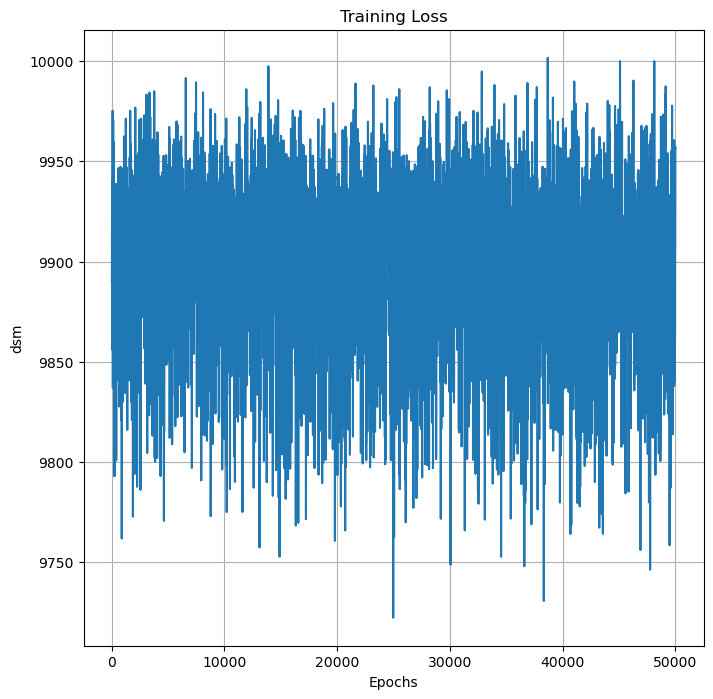

In [56]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [57]:
xs = pd.read_csv('Data/Ellipsoid'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/Ellipsoid'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [82]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.3]), 
                                     step_size=0.01, max_iter=1000)

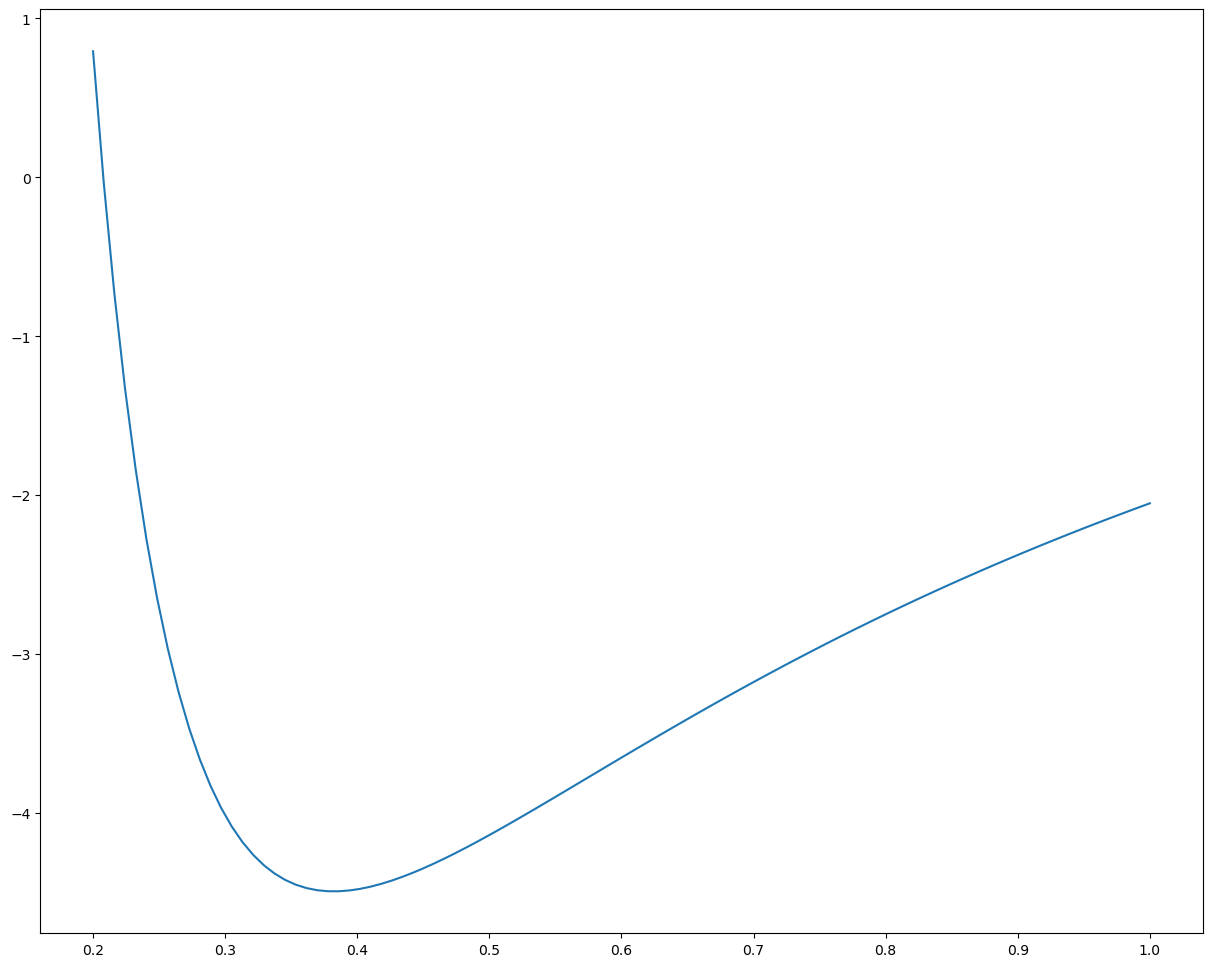

In [86]:
val = vmap(lambda t: jnp.mean(vmap(lambda x,chart: gradt_log(x0, (x,chart), t))(X_obs[0],X_obs[1]), axis=0))(jnp.linspace(0.2,1,100))
plt.plot(jnp.linspace(0.2,1,100), val)

In [84]:
val = jnp.mean(vmap(lambda x,chart: gradt_log(x0, (x,chart), 0.3))(X_obs[0],X_obs[1]), axis=0)
print(val)

-4.013881


In [87]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 4.656784e+00 | T: ((Array([-0.02380762,  0.01534564], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 1 | T: 4.108107e+00 | T: ((Array([-0.01414834,  0.00562849], dtype=float32), Array(0.21991655, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Final 1 | T: 4.108107e+00 | T: (Array([-0.01414834,  0.00562849], dtype=float32), Array(0.21991655, dtype=float32))
Step 0 | T: 4.659544e+00 | T: ((Array([-0.02380762,  0.01534564], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 1 | T: 4.109814e+00 | T: ((Array([-0.01414779,  0.00563325], dtype=float32), Array(0.21991652, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 2 | T: 3.660100e+00 | T: ((Array([-0.00516789, -0.00353058], dtype=float32), Array(0.22970444, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 3 | T: 3.295745e+00 | T: ((Array([ 0.00278716, -0.01183691], dtype=float32), Array(0.23932675, dtype=float32)), Ar

Step 51 | T: 1.079674e+00 | T: ((Array([ 0.00546334, -0.01574822], dtype=float32), Array(0.4495017, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 52 | T: 1.077063e+00 | T: ((Array([ 0.00535393, -0.01537904], dtype=float32), Array(0.450815, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 53 | T: 1.074983e+00 | T: ((Array([ 0.00519637, -0.0149759 ], dtype=float32), Array(0.45208225, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 54 | T: 1.075133e+00 | T: ((Array([ 0.00499119, -0.01455592], dtype=float32), Array(0.45330587, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 55 | T: 1.072461e+00 | T: ((Array([ 0.00475213, -0.01413589], dtype=float32), Array(0.45448768, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 56 | T: 1.071372e+00 | T: ((Array([ 0.00448844, -0.01372868], dtype=float32), Array(0.45563006, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 57 | T: 1.069775e+00 | T: ((Array([ 0.00419811, -0.01333753], dtype=float3

In [81]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[1][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.2818 0.3359 0.1734 -0.0184 0.0511 -0.0447 0.0011 0.0183 0.0044 0.0095 -0.1443 )
T = 0.0010


In [61]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:


NameError: name 'mu_bridgechart' is not defined

In [62]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt[-1][0]):.4f}")

The difference between the score and bridge:


NameError: name 'mu_bridgechart' is not defined

In [63]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_sm[1][-1])/N:.5f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_bridgechart[-1])/N:.5f} \n -T error = {jnp.abs(T_bridge[-1]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.09899 
 -T error = 0.4800


NameError: name 'mu_bridgechart' is not defined

In [92]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

1.34 s ± 4.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [93]:
%timeit M.diffusion_mean(X_obs,num_steps=100)

Step 0 | T: 4.656562e+00 | T: ((Array([-0.02380762,  0.01534564], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 1 | T: 4.110264e+00 | T: ((Array([-0.01414904,  0.00562994], dtype=float32), Array(0.21991679, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 2 | T: 3.660110e+00 | T: ((Array([-0.00516022, -0.00352163], dtype=float32), Array(0.22970495, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 3 | T: 3.294843e+00 | T: ((Array([ 0.00279815, -0.01182485], dtype=float32), Array(0.2393274, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 4 | T: 2.994320e+00 | T: ((Array([ 0.00941351, -0.01897685], dtype=float32), Array(0.24875428, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 5 | T: 2.744088e+00 | T: ((Array([ 0.01450081, -0.02477826], dtype=float32), Array(0.25796178, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 6 | T: 2.532049e+00 | T: ((Array([ 0.01811038, -0.02905273], dtype=float32), A

Step 54 | T: 1.074356e+00 | T: ((Array([ 0.0048395 , -0.01462019], dtype=float32), Array(0.4533135, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 55 | T: 1.072437e+00 | T: ((Array([ 0.00460536, -0.01418345], dtype=float32), Array(0.45449513, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 56 | T: 1.072083e+00 | T: ((Array([ 0.00434676, -0.01375451], dtype=float32), Array(0.4556374, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 57 | T: 1.070410e+00 | T: ((Array([ 0.00407332, -0.01335037], dtype=float32), Array(0.45674223, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 58 | T: 1.069486e+00 | T: ((Array([ 0.00378962, -0.01297385], dtype=float32), Array(0.45781136, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 59 | T: 1.069300e+00 | T: ((Array([ 0.00350289, -0.01263457], dtype=float32), Array(0.45884684, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 60 | T: 1.067418e+00 | T: ((Array([ 0.00322248, -0.0123378 ], dtype=float

Step 7 | T: 2.354910e+00 | T: ((Array([ 0.02014055, -0.03213925], dtype=float32), Array(0.27565128, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 8 | T: 2.198113e+00 | T: ((Array([ 0.02103149, -0.03380133], dtype=float32), Array(0.28410432, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 9 | T: 2.064346e+00 | T: ((Array([ 0.02090114, -0.03433661], dtype=float32), Array(0.29228517, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 10 | T: 1.946373e+00 | T: ((Array([ 0.01996153, -0.03393164], dtype=float32), Array(0.3001881, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 11 | T: 1.843269e+00 | T: ((Array([ 0.01840353, -0.03277338], dtype=float32), Array(0.30781, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 12 | T: 1.755532e+00 | T: ((Array([ 0.01639256, -0.03102046], dtype=float32), Array(0.31515032, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 13 | T: 1.675428e+00 | T: ((Array([ 0.01407603, -0.02883676], dtype=float32), 

Step 61 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 62 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 63 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 64 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 65 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 66 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 67 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 68 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 69 | T: nan | T: ((

Step 22 | T: 1.290768e+00 | T: ((Array([-0.00502316, -0.00732779], dtype=float32), Array(0.37390965, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 23 | T: 1.268680e+00 | T: ((Array([-0.00603562, -0.00599037], dtype=float32), Array(0.37847564, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 24 | T: 1.250884e+00 | T: ((Array([-0.00677099, -0.0049729 ], dtype=float32), Array(0.38283673, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 25 | T: 1.233799e+00 | T: ((Array([-0.00723908, -0.00426825], dtype=float32), Array(0.38700148, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 26 | T: 1.217584e+00 | T: ((Array([-0.00745961, -0.00386521], dtype=float32), Array(0.3909782, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 27 | T: 1.203780e+00 | T: ((Array([-0.00745496, -0.0037463 ], dtype=float32), Array(0.39477524, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 28 | T: 1.193098e+00 | T: ((Array([-0.00724466, -0.00388774], dtype=floa

Step 76 | T: 1.058105e+00 | T: ((Array([ 0.00141745, -0.01274753], dtype=float32), Array(0.47255984, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 77 | T: 1.057650e+00 | T: ((Array([ 0.00148627, -0.01290298], dtype=float32), Array(0.47319397, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 78 | T: 1.057077e+00 | T: ((Array([ 0.00156742, -0.0130413 ], dtype=float32), Array(0.47381327, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 79 | T: 1.057233e+00 | T: ((Array([ 0.00166253, -0.01315686], dtype=float32), Array(0.47441816, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 80 | T: 1.056363e+00 | T: ((Array([ 0.00176583, -0.01324944], dtype=float32), Array(0.47500923, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 81 | T: 1.056731e+00 | T: ((Array([ 0.00187057, -0.01332478], dtype=float32), Array(0.4755869, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 82 | T: 1.055404e+00 | T: ((Array([ 0.00197748, -0.01337825], dtype=floa

Step 29 | T: 1.180775e+00 | T: ((Array([-0.00693314, -0.00425226], dtype=float32), Array(0.4018634, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 30 | T: 1.170325e+00 | T: ((Array([-0.0064016 , -0.00481775], dtype=float32), Array(0.4051686, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 31 | T: 1.160797e+00 | T: ((Array([-0.00574267, -0.00554798], dtype=float32), Array(0.40832525, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 32 | T: 1.153065e+00 | T: ((Array([-0.00497917, -0.0064039 ], dtype=float32), Array(0.4113408, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 33 | T: 1.145056e+00 | T: ((Array([-0.00414244, -0.00735864], dtype=float32), Array(0.414222, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 34 | T: 1.138146e+00 | T: ((Array([-0.00325758, -0.00837988], dtype=float32), Array(0.41697562, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 35 | T: 1.131278e+00 | T: ((Array([-0.00234152, -0.00943494], dtype=float32)

Step 83 | T: 1.056111e+00 | T: ((Array([ 0.00205473, -0.01349261], dtype=float32), Array(0.4766943, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 84 | T: 1.054812e+00 | T: ((Array([ 0.00212826, -0.01354373], dtype=float32), Array(0.47723478, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 85 | T: 1.055271e+00 | T: ((Array([ 0.0022047 , -0.01357342], dtype=float32), Array(0.4777636, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 86 | T: 1.055407e+00 | T: ((Array([ 0.0022732 , -0.01357054], dtype=float32), Array(0.4782812, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 87 | T: 1.054619e+00 | T: ((Array([ 0.00233398, -0.0135548 ], dtype=float32), Array(0.47878763, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 88 | T: 1.053888e+00 | T: ((Array([ 0.00239376, -0.013527  ], dtype=float32), Array(0.47928327, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 89 | T: 1.053310e+00 | T: ((Array([ 0.00245247, -0.01348084], dtype=float3

Step 38 | T: 1.115554e+00 | T: ((Array([ 0.00039596, -0.01241525], dtype=float32), Array(0.4268527, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 39 | T: 1.110816e+00 | T: ((Array([ 0.00123299, -0.01331825], dtype=float32), Array(0.42905885, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 40 | T: 1.107059e+00 | T: ((Array([ 0.0020116 , -0.01413387], dtype=float32), Array(0.43117172, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 41 | T: 1.102853e+00 | T: ((Array([ 0.00272368, -0.01484684], dtype=float32), Array(0.43319616, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 42 | T: 1.099252e+00 | T: ((Array([ 0.00336176, -0.0154561 ], dtype=float32), Array(0.43513682, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 43 | T: 1.096593e+00 | T: ((Array([ 0.00391874, -0.01594463], dtype=float32), Array(0.43699834, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 44 | T: 1.093819e+00 | T: ((Array([ 0.00439286, -0.01631708], dtype=floa

Step 92 | T: 1.052755e+00 | T: ((Array([ 0.00260553, -0.01336932], dtype=float32), Array(0.4811315, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 93 | T: 1.053618e+00 | T: ((Array([ 0.00262891, -0.01332881], dtype=float32), Array(0.4815785, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 94 | T: 1.052799e+00 | T: ((Array([ 0.00265262, -0.01327743], dtype=float32), Array(0.4820164, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 95 | T: -inf | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 96 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 97 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 98 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 99 | T: nan | T: ((Array([nan, nan], dtype=floa

Step 46 | T: 1.088332e+00 | T: ((Array([ 0.00496003, -0.01671754], dtype=float32), Array(0.4421613, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 47 | T: 1.087091e+00 | T: ((Array([ 0.00517821, -0.01673128], dtype=float32), Array(0.44374615, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 48 | T: 1.084368e+00 | T: ((Array([ 0.00532058, -0.01664142], dtype=float32), Array(0.44527078, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 49 | T: 1.081895e+00 | T: ((Array([ 0.00540899, -0.01647458], dtype=float32), Array(0.44673887, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 50 | T: 1.080270e+00 | T: ((Array([ 0.0054317 , -0.01623163], dtype=float32), Array(0.4481527, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 51 | T: 1.078944e+00 | T: ((Array([ 0.00538274, -0.01593353], dtype=float32), Array(0.44951525, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 52 | T: 1.076513e+00 | T: ((Array([ 0.00527479, -0.01556865], dtype=float

Step 0 | T: 4.655128e+00 | T: ((Array([-0.02380762,  0.01534564], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 1 | T: 4.106120e+00 | T: ((Array([-0.01414666,  0.00562299], dtype=float32), Array(0.21991634, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 2 | T: 3.659603e+00 | T: ((Array([-0.00515824, -0.00354523], dtype=float32), Array(0.22970456, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 3 | T: 3.295960e+00 | T: ((Array([ 0.00280037, -0.01183993], dtype=float32), Array(0.23932777, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 4 | T: 2.994792e+00 | T: ((Array([ 0.0094226 , -0.01899558], dtype=float32), Array(0.24875562, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 5 | T: 2.743244e+00 | T: ((Array([ 0.01452888, -0.02479064], dtype=float32), Array(0.25796407, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 6 | T: 2.531782e+00 | T: ((Array([ 0.01809513, -0.02912832], dtype=float32), 

Step 54 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 55 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 56 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 57 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 58 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 59 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 60 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 61 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 62 | T: nan | T: ((

Step 17 | T: 1.448024e+00 | T: ((Array([ 0.0041052 , -0.01826715], dtype=float32), Array(0.34770098, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 18 | T: 1.408658e+00 | T: ((Array([ 0.00179836, -0.01566181], dtype=float32), Array(0.3534216, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 19 | T: 1.373182e+00 | T: ((Array([-0.00030388, -0.01322982], dtype=float32), Array(0.35889474, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 20 | T: 1.341673e+00 | T: ((Array([-0.00216577, -0.01101731], dtype=float32), Array(0.36412832, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 21 | T: 1.313572e+00 | T: ((Array([-0.00375684, -0.00907764], dtype=float32), Array(0.3691306, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 22 | T: 1.291013e+00 | T: ((Array([-0.00506689, -0.00743143], dtype=float32), Array(0.3739105, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 23 | T: 1.267735e+00 | T: ((Array([-0.00610477, -0.00609647], dtype=float3

Step 76 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 77 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 78 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 79 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 80 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 81 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 82 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 83 | T: nan | T: ((Array([nan, nan], dtype=float32), Array(nan, dtype=float32)), Array([0., 0., 1.], dtype=float32))
Step 84 | T: nan | T: ((

# Cylinder

## Defining Manifold and Loading Score

In [160]:
M = Cylinder(params=(1.,jnp.array([0.,0.,1.]),jnp.pi/2.))
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)
x0[1]

using M.Exp for Logarithm


Array([0., 0.], dtype=float32)

In [116]:
file_path = 'scores/Cylinder/'+ loss_type + '/'
state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), M.F(y))), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), M.F(y))), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

## Loading Loss

In [117]:
loss = jnp.load('scores/Cylinder/' + loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


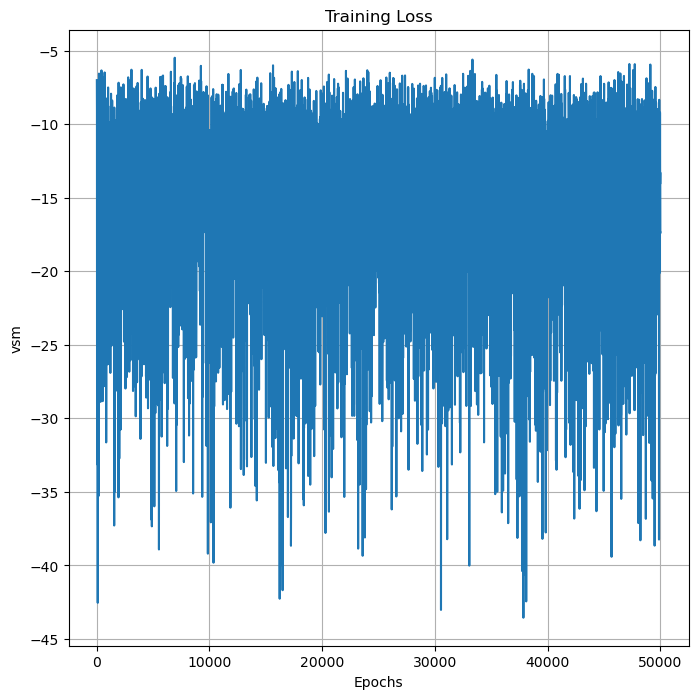

In [81]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [82]:
xs = pd.read_csv('Data/Cylinder/xs.csv', header=None)
charts = pd.read_csv('Data/Cylinder/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [83]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                     step_size=0.1, max_iter=100)

In [84]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 1.130957e+01 | T: ((Array([-0.02587204,  0.06452829], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0.], dtype=float32))
Step 1 | T: 1.021403e+01 | T: ((Array([-0.03275904,  0.05470097], dtype=float32), Array(0.21992894, dtype=float32)), Array([0., 0.], dtype=float32))
Final 1 | T: 1.021403e+01 | T: (Array([-0.03275904,  0.05470097], dtype=float32), Array(0.21992894, dtype=float32))
Step 0 | T: 1.130957e+01 | T: ((Array([-0.02587204,  0.06452829], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0.], dtype=float32))
Step 1 | T: 1.021403e+01 | T: ((Array([-0.03275904,  0.05470097], dtype=float32), Array(0.21992894, dtype=float32)), Array([0., 0.], dtype=float32))
Step 2 | T: 9.283365e+00 | T: ((Array([-0.03446573,  0.04518323], dtype=float32), Array(0.2297475, dtype=float32)), Array([0., 0.], dtype=float32))
Step 3 | T: 8.488744e+00 | T: ((Array([-0.03292985,  0.03612189], dtype=float32), Array(0.23942202, dtype=float32)), Array([0., 0.], dtype=f

Step 53 | T: 2.569135e+00 | T: ((Array([-0.02585055,  0.01791908], dtype=float32), Array(0.4813849, dtype=float32)), Array([0., 0.], dtype=float32))
Step 54 | T: 2.558720e+00 | T: ((Array([-0.02608876,  0.01736902], dtype=float32), Array(0.48343876, dtype=float32)), Array([0., 0.], dtype=float32))
Step 55 | T: 2.548722e+00 | T: ((Array([-0.02631092,  0.01685355], dtype=float32), Array(0.48545206, dtype=float32)), Array([0., 0.], dtype=float32))
Step 56 | T: 2.539115e+00 | T: ((Array([-0.02650013,  0.01637699], dtype=float32), Array(0.48742664, dtype=float32)), Array([0., 0.], dtype=float32))
Step 57 | T: 2.529876e+00 | T: ((Array([-0.02664378,  0.01594271], dtype=float32), Array(0.48936433, dtype=float32)), Array([0., 0.], dtype=float32))
Step 58 | T: 2.520983e+00 | T: ((Array([-0.02673416,  0.01555317], dtype=float32), Array(0.49126676, dtype=float32)), Array([0., 0.], dtype=float32))
Step 59 | T: 2.512416e+00 | T: ((Array([-0.02676868,  0.01520993], dtype=float32), Array(0.4931355, d

In [85]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[1][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( -0.0341 0.0185 )
T = 0.5071


In [86]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( 0.0000 0.0000 )
T = 0.5507


In [87]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_sm[-1][0]):.4f}")

The difference between the score and bridge:
Score Diffusion mean: 
 -mean error = 0.0388 
 -T error = 0.0436


In [89]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_sm[1][-1])/2:.5f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_bridgechart[-1])/2:.5f} \n -T error = {jnp.abs(T_bridge[-1]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.01940 
 -T error = 0.0071
Bridge Diffusion mean: 
 -mean error = 0.00000 
 -T error = 0.0507


In [ ]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

In [ ]:
%timeit M.diffusion_mean(X_obs,num_steps=100)

# Torus

## Defining Manifold and Loading Score

In [163]:
M = Torus()
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)
x0[1]

using M.Exp for Logarithm


Array([0., 0.], dtype=float32)

In [119]:
file_path = 'scores/Torus/'+ loss_type + '/'
state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), M.F(y))), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), M.F(y))), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

## Loading Loss

In [120]:
loss = jnp.load('scores/Torus/' + loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


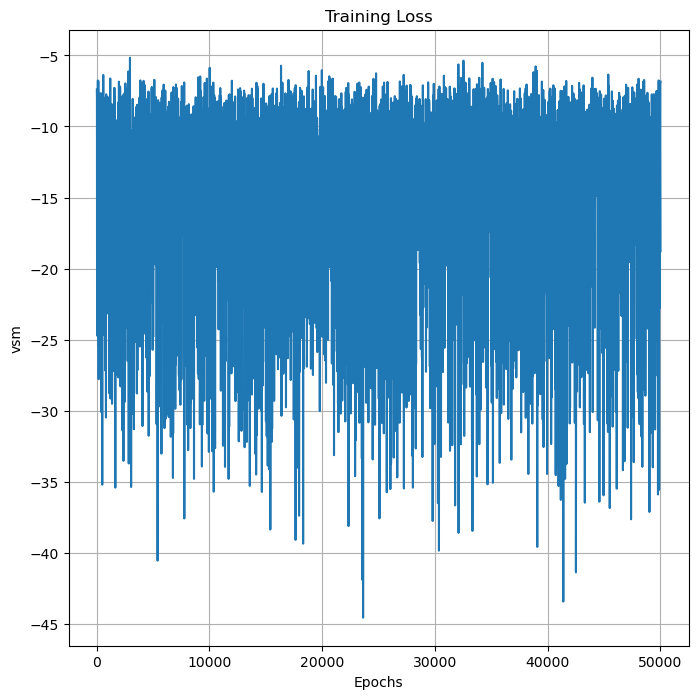

In [93]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [94]:
xs = pd.read_csv('Data/Torus/xs.csv', header=None)
charts = pd.read_csv('Data/Torus/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [95]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), 
                                     step_size=0.1, max_iter=100)

In [96]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 1.453338e+01 | T: ((Array([-0.18177876, -0.00945805], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0.], dtype=float32))
Step 1 | T: 1.265824e+01 | T: ((Array([-0.17184542, -0.01500721], dtype=float32), Array(0.219913, dtype=float32)), Array([0., 0.], dtype=float32))
Final 1 | T: 1.265824e+01 | T: (Array([-0.17184542, -0.01500721], dtype=float32), Array(0.219913, dtype=float32))
Step 0 | T: 1.453340e+01 | T: ((Array([-0.18177876, -0.00945805], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0.], dtype=float32))
Step 1 | T: 1.265763e+01 | T: ((Array([-0.17184542, -0.015028  ], dtype=float32), Array(0.21991298, dtype=float32)), Array([0., 0.], dtype=float32))
Step 2 | T: 1.108802e+01 | T: ((Array([-0.16201945, -0.02065388], dtype=float32), Array(0.22969085, dtype=float32)), Array([0., 0.], dtype=float32))
Step 3 | T: 9.771928e+00 | T: ((Array([-0.15233807, -0.02273714], dtype=float32), Array(0.2392931, dtype=float32)), Array([0., 0.], dtype=float

Step 53 | T: 1.572088e+00 | T: ((Array([ 0.01941139, -0.01369051], dtype=float32), Array(0.46345207, dtype=float32)), Array([0., 0.], dtype=float32))
Step 54 | T: 1.560797e+00 | T: ((Array([ 0.01918913, -0.0135701 ], dtype=float32), Array(0.4653291, dtype=float32)), Array([0., 0.], dtype=float32))
Step 55 | T: 1.549640e+00 | T: ((Array([ 0.01893759, -0.01354981], dtype=float32), Array(0.46717286, dtype=float32)), Array([0., 0.], dtype=float32))
Step 56 | T: 1.538876e+00 | T: ((Array([ 0.01866033, -0.0136252 ], dtype=float32), Array(0.4689849, dtype=float32)), Array([0., 0.], dtype=float32))
Step 57 | T: 1.528749e+00 | T: ((Array([ 0.01836071, -0.01377137], dtype=float32), Array(0.4707667, dtype=float32)), Array([0., 0.], dtype=float32))
Step 58 | T: 1.518717e+00 | T: ((Array([ 0.01804182, -0.01395113], dtype=float32), Array(0.47251964, dtype=float32)), Array([0., 0.], dtype=float32))
Step 59 | T: 1.508847e+00 | T: ((Array([ 0.01770659, -0.01414127], dtype=float32), Array(0.47424498, dt

In [97]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[1][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0266 -0.0372 )
T = 0.5016


In [98]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( 0.0000 0.0000 )
T = 0.5290


In [99]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_sm[-1][0]):.4f}")

The difference between the score and bridge:
Score Diffusion mean: 
 -mean error = 0.0457 
 -T error = 0.0274


In [101]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_sm[1][-1])/2:.5f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_bridgechart[-1])/2:.5f} \n -T error = {jnp.abs(T_bridge[-1]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.02286 
 -T error = 0.0016
Bridge Diffusion mean: 
 -mean error = 0.00000 
 -T error = 0.0290


In [ ]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

In [ ]:
%timeit M.diffusion_mean(X_obs,num_steps=100)

# Hyperbolic Parabolid

## Defining Manifold and Loading Score

In [155]:
M = HypParaboloid()
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)

using M.Exp for Logarithm


In [157]:
file_path = 'scores/HypParaboloid/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

## Loading Loss

In [158]:
loss = jnp.load('scores/HypParaboloid/s1_' + loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


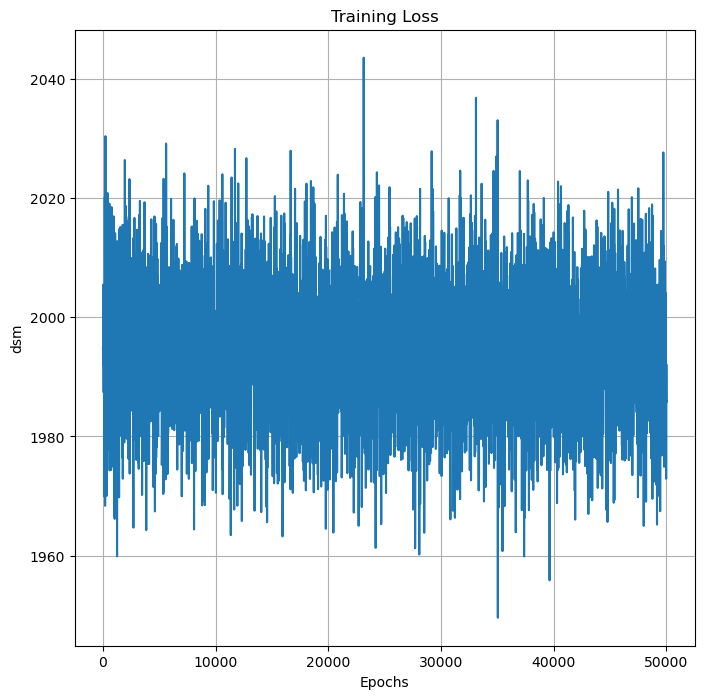

In [159]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [170]:
xs = pd.read_csv('Data/HypParaboloid/xs.csv', header=None)
charts = pd.read_csv('Data/HypParaboloid/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [174]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.3]), 
                                     step_size=0.001, max_iter=1000)

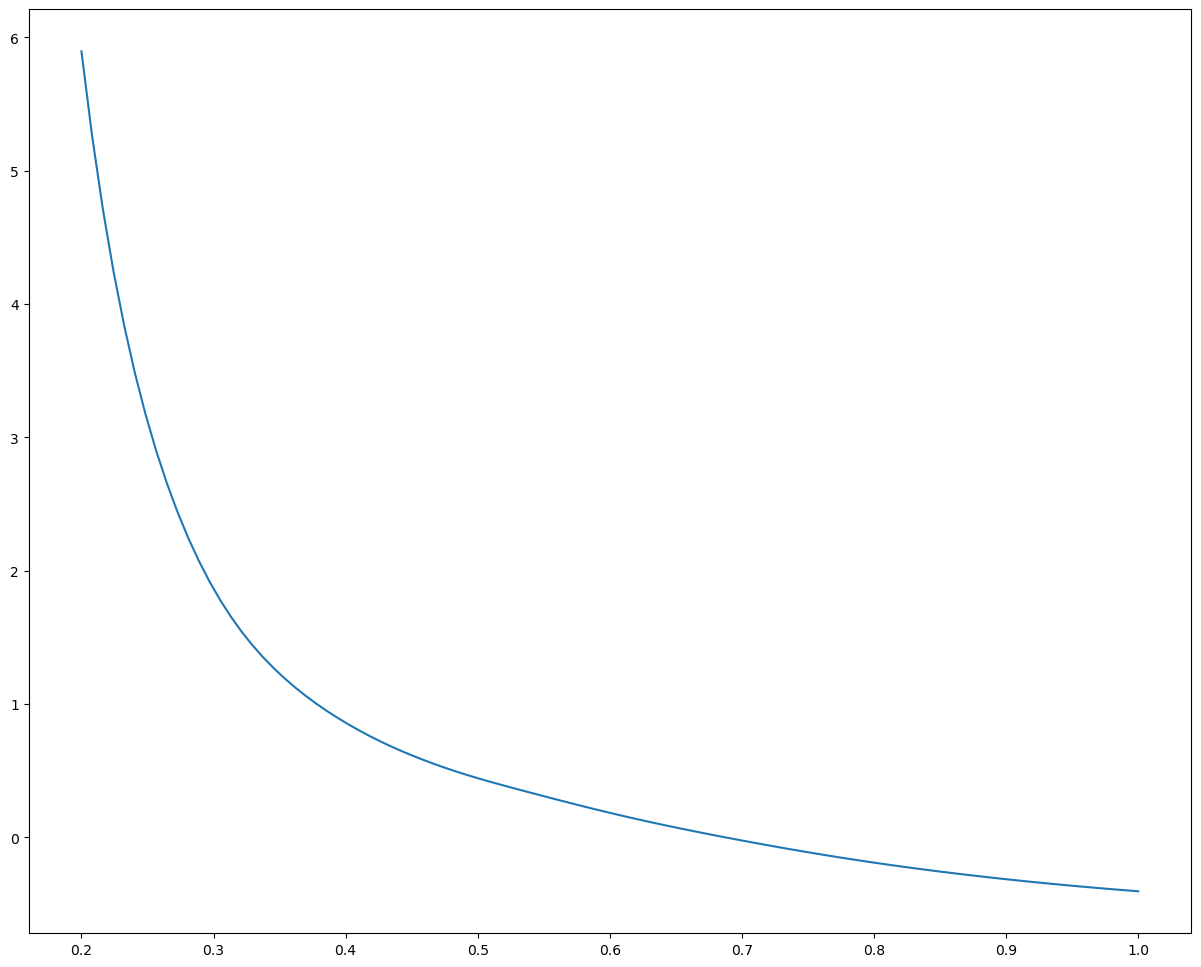

In [177]:
val = vmap(lambda t: jnp.mean(vmap(lambda x,chart: gradt_log((mu_sm[0][-1], mu_sm[1][-1]), (x,chart), t))(X_obs[0],X_obs[1]), axis=0))(jnp.linspace(0.2,1,100))
plt.plot(jnp.linspace(0.2,1,100), val)

In [109]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

ValueError: The user-provided objective function must return a scalar value.

In [175]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[0][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.2148 -0.7179 )
T = 0.7120


In [173]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:


NameError: name 'mu_bridgechart' is not defined

In [112]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_sm[-1][0]):.4f}")

The difference between the score and bridge:
Score Diffusion mean: 
 -mean error = 0.0000 
 -T error = 0.4710


In [167]:
M.F((mu_sm[0][-1], mu_sm[1][-1]))

Array([  1.0282233,  -3.7317057, -12.868383 ], dtype=float32)

In [166]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[0]-mu_sm[0][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_bridgechart[-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 3.8708 
 -T error = 0.2000


NameError: name 'mu_bridgechart' is not defined

In [253]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

426 ms ± 7.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit M.diffusion_mean(X_obs,num_steps=100)

# SPDN

## Defining Manifold and Loading Score

In [150]:
N = 10

In [151]:
M = SPDN(N=N)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([10.]*(N*(N+1)//2))

using M.Exp for Logarithm


In [177]:
file_path = 'scores/SPDN'+str(N)+'/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)
from jax import jacfwd
if N*N<10:
    layers = [50,100,100,50]
elif N*N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    #ggrad = s2.apply(state_s2.params, rng_key, jnp.hstack((x[0],y[0],t)))
    
    return ggrad

## Loading Loss

In [178]:
loss = jnp.load('scores/SPDN'+str(N)+'/s1_'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  60


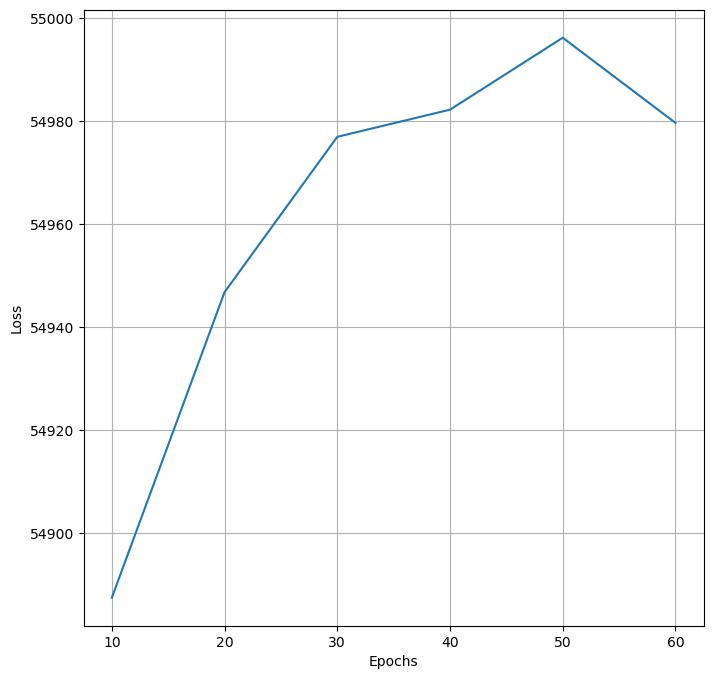

In [179]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [180]:
xs = pd.read_csv('Data/SPDN'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/SPDN'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values)[~jnp.isnan(xs.values).any(axis=1)], jnp.array(charts.values)[~jnp.isnan(xs.values).any(axis=1)])

In [184]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.3]), 
                                     step_size=0.01, max_iter=1000)

In [186]:
val = vmap(lambda t: jnp.mean(vmap(lambda x,chart: gradt_log(x0, (x,chart), t))(X_obs[0],X_obs[1]), axis=0))(jnp.linspace(0.2,1,100))
plt.plot(jnp.linspace(0.2,1,100), val)

KeyboardInterrupt: 

In [40]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

ValueError: The user-provided objective function must return a scalar value.

In [182]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[0]-mu_sm[0][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.0220 
 -T error = 0.4990


In [140]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

1min 7s ± 2.18 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Landmarks

## Defining Manifold and Loading Score

In [16]:
N = 2

In [17]:
M = Landmarks(N=N,m=2)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords(jnp.vstack((jnp.linspace(-5.0,5.0,M.N),jnp.linspace(5.0,-5.0,M.N))).T.flatten())
x0 = M.coords(jnp.vstack((jnp.linspace(-5.0,5.0,M.N),jnp.zeros(M.N))).T.flatten())
if N >=10:
    with open('../../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt', 'r') as the_file:
        all_data = [line.strip() for line in the_file.readlines()]

        x1 = jnp.array([float(x) for x in all_data[0].split()[2:]])
        x2 = jnp.array([float(x) for x in all_data[1].split()[2:]])

        x0 = M.coords(jnp.vstack((x1[::len(x1)//N],x2[::len(x2)//N])).T.flatten())

using M.Exp for Logarithm


In [18]:
x0[0].reshape(-1,2)

Array([[-5.,  0.],
       [ 5.,  0.]], dtype=float32)

In [19]:
file_path = 'scores/Landmarks'+str(N)+'/s1_'+ loss_type + '/'
state = model_loader.load_model(file_path)

file_path_s2 = 'scores/Landmarks'+str(N)+'/s2/'
state_s2 = model_loader.load_model(file_path_s2)
if 2*N<10:
    layers = [50,100,100,50]
elif 2*N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    ggrad = s2.apply(state_s2.params,rng_key, jnp.hstack((x[0], y[0], t)))
    
    return ggrad

## Loading Loss

In [20]:
loss = jnp.load('scores/Landmarks'+str(N)+'/s1_'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


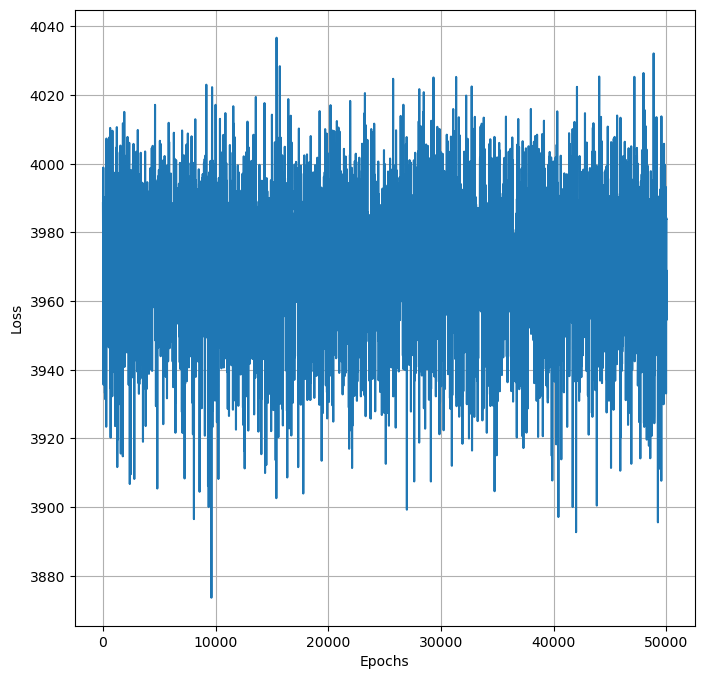

In [21]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

In [22]:
loss = jnp.load('scores/Landmarks'+str(N)+'/s2/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  200


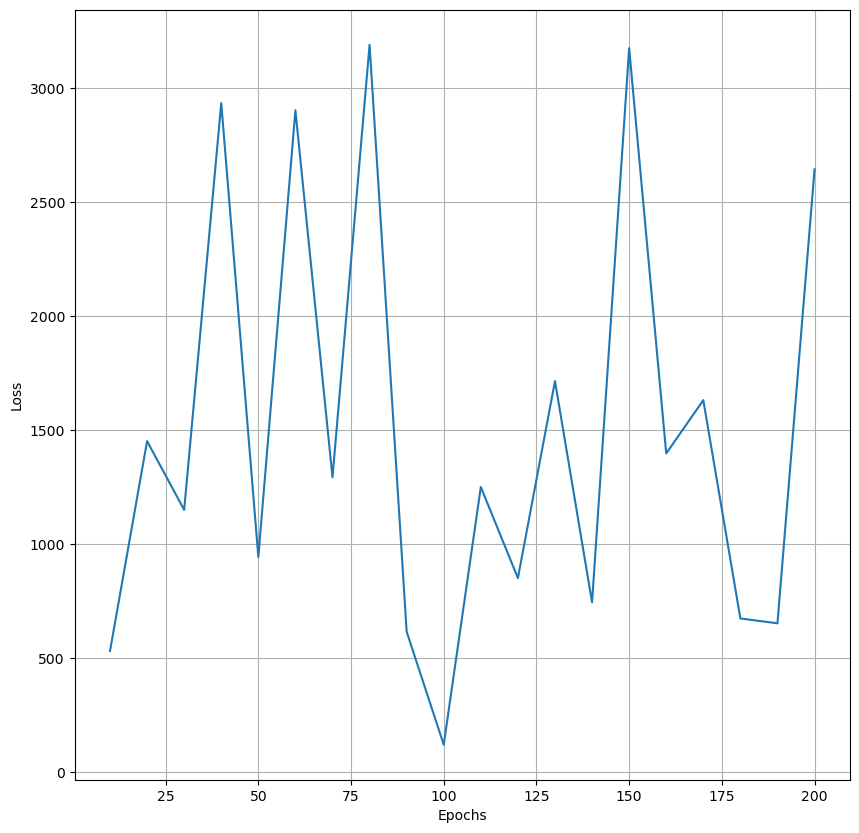

In [23]:
fig = plt.figure(figsize=(10,10))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [24]:
xs = pd.read_csv('Data/Landmarks'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/Landmarks'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [25]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                    step_size=0.1, max_iter=100)

In [331]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

ValueError: The user-provided objective function must return a scalar value.

In [26]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[0][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( -4.9548 -0.0284 4.9063 0.0468 )
T = 0.6400


In [27]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[0]-mu_sm[0][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.1175 
 -T error = 0.1400


In [334]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

10.1 s ± 2.39 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
